In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17             

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-08 06:18:20,254] A new study created in memory with name: no-name-f6ebbffe-b06f-494b-8e48-64a0151d581b
[I 2025-06-08 06:22:57,368] Trial 0 finished with value: 0.17817918658256532 and parameters: {'lr': 0.06899505507749709, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.15119574460464846}. Best is trial 0 with value: 0.17817918658256532.


Cross Validation Accuracies:
[0.17360460758209229, 0.17826472222805023, 0.2574290335178375, 0.14654438197612762, 0.13505318760871887]
Mean Cross Validation Accuracy:
0.17817918658256532
Standard Deviation of Cross Validation Accuracy:
0.042806740073549135


[I 2025-06-08 06:27:15,193] Trial 1 finished with value: 0.45919630527496336 and parameters: {'lr': 0.007154000034161632, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.10761847613758105}. Best is trial 0 with value: 0.17817918658256532.


Cross Validation Accuracies:
[0.5339149832725525, 0.47422632575035095, 0.38199466466903687, 0.46190300583839417, 0.4439425468444824]
Mean Cross Validation Accuracy:
0.45919630527496336
Standard Deviation of Cross Validation Accuracy:
0.04900791577620939


[I 2025-06-08 06:32:06,761] Trial 2 finished with value: 0.10028203725814819 and parameters: {'lr': 0.6907196162124891, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3209171701330773}. Best is trial 2 with value: 0.10028203725814819.


Cross Validation Accuracies:
[0.14567705988883972, 0.0867735892534256, 0.11184928566217422, 0.08630634844303131, 0.07080390304327011]
Mean Cross Validation Accuracy:
0.10028203725814819
Standard Deviation of Cross Validation Accuracy:
0.026234586931854223


[I 2025-06-08 06:37:17,513] Trial 3 finished with value: 0.15676686763763428 and parameters: {'lr': 0.0015561248266493023, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.26412291320816955}. Best is trial 2 with value: 0.10028203725814819.


Cross Validation Accuracies:
[0.16891632974147797, 0.15491342544555664, 0.13911643624305725, 0.13825908303260803, 0.1826290637254715]
Mean Cross Validation Accuracy:
0.15676686763763428
Standard Deviation of Cross Validation Accuracy:
0.017169587550425122


[I 2025-06-08 06:42:34,231] Trial 4 finished with value: 0.0964682400226593 and parameters: {'lr': 0.18313942913855627, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.34371054405647816}. Best is trial 4 with value: 0.0964682400226593.


Cross Validation Accuracies:
[0.1440022587776184, 0.08613357692956924, 0.10827009379863739, 0.07430446147918701, 0.06963080912828445]
Mean Cross Validation Accuracy:
0.0964682400226593
Standard Deviation of Cross Validation Accuracy:
0.027265556033679115


[I 2025-06-08 06:46:59,488] Trial 5 finished with value: 0.16059630513191223 and parameters: {'lr': 0.0012258362586447214, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3428017339185273}. Best is trial 4 with value: 0.0964682400226593.


Cross Validation Accuracies:
[0.09121529757976532, 0.19637741148471832, 0.22902899980545044, 0.1488124430179596, 0.13754737377166748]
Mean Cross Validation Accuracy:
0.16059630513191223
Standard Deviation of Cross Validation Accuracy:
0.04784800544272146


[I 2025-06-08 06:51:42,325] Trial 6 finished with value: 0.0964754655957222 and parameters: {'lr': 0.036850640234086116, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3427137985155503}. Best is trial 4 with value: 0.0964682400226593.


Cross Validation Accuracies:
[0.14322486519813538, 0.08644433319568634, 0.10099062323570251, 0.08070375770330429, 0.07101374864578247]
Mean Cross Validation Accuracy:
0.0964754655957222
Standard Deviation of Cross Validation Accuracy:
0.025312299100672925


[I 2025-06-08 06:57:33,912] Trial 7 finished with value: 0.09976999759674073 and parameters: {'lr': 0.01755301076479799, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19478409553105763}. Best is trial 4 with value: 0.0964682400226593.


Cross Validation Accuracies:
[0.1435130089521408, 0.0862087681889534, 0.10210515558719635, 0.07942670583724976, 0.0875963494181633]
Mean Cross Validation Accuracy:
0.09976999759674073
Standard Deviation of Cross Validation Accuracy:
0.023086178453426368


[I 2025-06-08 07:02:48,409] Trial 8 finished with value: 0.10077278763055801 and parameters: {'lr': 0.1219481131990147, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.22887776981035848}. Best is trial 4 with value: 0.0964682400226593.


Cross Validation Accuracies:
[0.13675306737422943, 0.08280348032712936, 0.12491226941347122, 0.08562542498111725, 0.0737696960568428]
Mean Cross Validation Accuracy:
0.10077278763055801
Standard Deviation of Cross Validation Accuracy:
0.02513483903237746


[I 2025-06-08 07:07:43,179] Trial 9 finished with value: 0.7381611943244935 and parameters: {'lr': 0.09254384246958612, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.29456367830789787}. Best is trial 4 with value: 0.0964682400226593.


Cross Validation Accuracies:
[0.8520398139953613, 0.47649455070495605, 0.6958480477333069, 1.0980829000473022, 0.5683406591415405]
Mean Cross Validation Accuracy:
0.7381611943244935
Standard Deviation of Cross Validation Accuracy:
0.2198230302747845


[I 2025-06-08 07:12:42,729] Trial 10 finished with value: 0.09817458391189575 and parameters: {'lr': 0.811574697358168, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.46400872144955246}. Best is trial 4 with value: 0.0964682400226593.


Cross Validation Accuracies:
[0.1307690590620041, 0.07649029791355133, 0.12141191959381104, 0.08540727943181992, 0.07679436355829239]
Mean Cross Validation Accuracy:
0.09817458391189575
Standard Deviation of Cross Validation Accuracy:
0.023206463432495


[I 2025-06-08 07:18:00,298] Trial 11 finished with value: 0.09839044064283371 and parameters: {'lr': 0.23699656818373452, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.40166917644572175}. Best is trial 4 with value: 0.0964682400226593.


Cross Validation Accuracies:
[0.13790611922740936, 0.08936967700719833, 0.09637820720672607, 0.09713830798864365, 0.07115989178419113]
Mean Cross Validation Accuracy:
0.09839044064283371
Standard Deviation of Cross Validation Accuracy:
0.021863132169465067


[I 2025-06-08 07:23:36,101] Trial 12 finished with value: 0.09721180498600006 and parameters: {'lr': 0.02101080542179354, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.38449576242669253}. Best is trial 4 with value: 0.0964682400226593.


Cross Validation Accuracies:
[0.14590679109096527, 0.08635549247264862, 0.10217916965484619, 0.08057954907417297, 0.07103802263736725]
Mean Cross Validation Accuracy:
0.09721180498600006
Standard Deviation of Cross Validation Accuracy:
0.026364501603685652


[I 2025-06-08 07:28:01,591] Trial 13 finished with value: 0.09380306601524353 and parameters: {'lr': 0.0069542849681772925, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.48984420160988024}. Best is trial 13 with value: 0.09380306601524353.


Cross Validation Accuracies:
[0.14193738996982574, 0.08515433222055435, 0.08919854462146759, 0.08220205456018448, 0.07052300870418549]
Mean Cross Validation Accuracy:
0.09380306601524353
Standard Deviation of Cross Validation Accuracy:
0.02485743305841681


[I 2025-06-08 07:33:29,894] Trial 14 finished with value: 0.26723662614822385 and parameters: {'lr': 0.0074557573361179056, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4894173244485281}. Best is trial 13 with value: 0.09380306601524353.


Cross Validation Accuracies:
[0.23927024006843567, 0.21815472841262817, 0.3072091341018677, 0.32919615507125854, 0.24235287308692932]
Mean Cross Validation Accuracy:
0.26723662614822385
Standard Deviation of Cross Validation Accuracy:
0.04300496998853788


[I 2025-06-08 07:38:04,495] Trial 15 finished with value: 0.08769798576831818 and parameters: {'lr': 0.004406663978399368, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4304211669249866}. Best is trial 15 with value: 0.08769798576831818.


Cross Validation Accuracies:
[0.10419190675020218, 0.08436150848865509, 0.1053847074508667, 0.07448013126850128, 0.07007167488336563]
Mean Cross Validation Accuracy:
0.08769798576831818
Standard Deviation of Cross Validation Accuracy:
0.014706462163699328


[I 2025-06-08 07:43:20,516] Trial 16 finished with value: 0.08506962507963181 and parameters: {'lr': 0.003642086442361483, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.433475624146677}. Best is trial 16 with value: 0.08506962507963181.


Cross Validation Accuracies:
[0.13032501935958862, 0.0765114277601242, 0.06292518973350525, 0.0791313424706459, 0.07645514607429504]
Mean Cross Validation Accuracy:
0.08506962507963181
Standard Deviation of Cross Validation Accuracy:
0.023328703000682773


[I 2025-06-08 07:48:39,178] Trial 17 finished with value: 0.0937665045261383 and parameters: {'lr': 0.0024411286828395487, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4366022982386699}. Best is trial 16 with value: 0.08506962507963181.


Cross Validation Accuracies:
[0.1189485490322113, 0.09758458286523819, 0.09696493297815323, 0.08270706236362457, 0.07262739539146423]
Mean Cross Validation Accuracy:
0.0937665045261383
Standard Deviation of Cross Validation Accuracy:
0.01567237204909104


[I 2025-06-08 07:53:34,499] Trial 18 finished with value: 0.0917627140879631 and parameters: {'lr': 0.003112028282718478, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.41229257520528695}. Best is trial 16 with value: 0.08506962507963181.


Cross Validation Accuracies:
[0.14684829115867615, 0.08286048471927643, 0.06724472343921661, 0.08321036398410797, 0.07864970713853836]
Mean Cross Validation Accuracy:
0.0917627140879631
Standard Deviation of Cross Validation Accuracy:
0.02814212500133125


[I 2025-06-08 07:58:39,443] Trial 19 finished with value: 0.07719398736953735 and parameters: {'lr': 0.004110485506870843, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.43462940780665077}. Best is trial 19 with value: 0.07719398736953735.


Cross Validation Accuracies:
[0.11548464000225067, 0.06010603904724121, 0.0750490203499794, 0.0671745091676712, 0.06815572828054428]
Mean Cross Validation Accuracy:
0.07719398736953735
Standard Deviation of Cross Validation Accuracy:
0.019722337646521558


[I 2025-06-08 08:03:52,716] Trial 20 finished with value: 0.11162932962179184 and parameters: {'lr': 0.012128469048470968, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3910285101283975}. Best is trial 19 with value: 0.07719398736953735.


Cross Validation Accuracies:
[0.14641152322292328, 0.12248385697603226, 0.10703759640455246, 0.09405543655157089, 0.08815823495388031]
Mean Cross Validation Accuracy:
0.11162932962179184
Standard Deviation of Cross Validation Accuracy:
0.02101637348489252


[I 2025-06-08 08:08:54,253] Trial 21 finished with value: 0.07574673444032669 and parameters: {'lr': 0.003720100573610389, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4319269803964015}. Best is trial 21 with value: 0.07574673444032669.


Cross Validation Accuracies:
[0.09922385960817337, 0.07454311102628708, 0.06761744618415833, 0.07083557546138763, 0.06651367992162704]
Mean Cross Validation Accuracy:
0.07574673444032669
Standard Deviation of Cross Validation Accuracy:
0.012067130738358106


[I 2025-06-08 08:13:57,643] Trial 22 finished with value: 0.07212707102298736 and parameters: {'lr': 0.0019560755541161937, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4571985472946435}. Best is trial 22 with value: 0.07212707102298736.


Cross Validation Accuracies:
[0.06927323341369629, 0.07557439059019089, 0.06561104208230972, 0.08041828870773315, 0.06975840032100677]
Mean Cross Validation Accuracy:
0.07212707102298736
Standard Deviation of Cross Validation Accuracy:
0.005231480212036353


[I 2025-06-08 08:18:53,023] Trial 23 finished with value: 0.06954522132873535 and parameters: {'lr': 0.0010044728942022005, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.46103034554289174}. Best is trial 23 with value: 0.06954522132873535.


Cross Validation Accuracies:
[0.07493074983358383, 0.07037205994129181, 0.06380335986614227, 0.0704101100564003, 0.06820982694625854]
Mean Cross Validation Accuracy:
0.06954522132873535
Standard Deviation of Cross Validation Accuracy:
0.0036107579008112364


[I 2025-06-08 08:23:48,393] Trial 24 finished with value: 0.07318624630570411 and parameters: {'lr': 0.0016738089947643054, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.47898201953364905}. Best is trial 23 with value: 0.06954522132873535.


Cross Validation Accuracies:
[0.06051350384950638, 0.09254403412342072, 0.07458213716745377, 0.07995442301034927, 0.05833713337779045]
Mean Cross Validation Accuracy:
0.07318624630570411
Standard Deviation of Cross Validation Accuracy:
0.012677343826732823


[I 2025-06-08 08:28:49,167] Trial 25 finished with value: 0.10357335507869721 and parameters: {'lr': 0.0011782698458868977, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.49806145628019244}. Best is trial 23 with value: 0.06954522132873535.


Cross Validation Accuracies:
[0.1170625314116478, 0.0747205838561058, 0.10862716287374496, 0.09760035574436188, 0.11985614150762558]
Mean Cross Validation Accuracy:
0.10357335507869721
Standard Deviation of Cross Validation Accuracy:
0.01637551289903301


[I 2025-06-08 08:33:41,760] Trial 26 finished with value: 0.06937340050935745 and parameters: {'lr': 0.0020676036704598355, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4629791959699791}. Best is trial 26 with value: 0.06937340050935745.


Cross Validation Accuracies:
[0.06568393856287003, 0.06193861365318298, 0.0953659936785698, 0.06420528143644333, 0.05967317521572113]
Mean Cross Validation Accuracy:
0.06937340050935745
Standard Deviation of Cross Validation Accuracy:
0.013155279626147277


[I 2025-06-08 08:38:51,906] Trial 27 finished with value: 0.071038256585598 and parameters: {'lr': 0.0010072595109041058, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3771699096300294}. Best is trial 26 with value: 0.06937340050935745.


Cross Validation Accuracies:
[0.06174568086862564, 0.081074059009552, 0.055990494787693024, 0.09324241429567337, 0.06313863396644592]
Mean Cross Validation Accuracy:
0.071038256585598
Standard Deviation of Cross Validation Accuracy:
0.013920726173685857


[I 2025-06-08 08:44:02,751] Trial 28 finished with value: 0.06922417879104614 and parameters: {'lr': 0.0011753175329698678, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3773344227577383}. Best is trial 28 with value: 0.06922417879104614.


Cross Validation Accuracies:
[0.07298791408538818, 0.06307192891836166, 0.0637638121843338, 0.08075004070997238, 0.06554719805717468]
Mean Cross Validation Accuracy:
0.06922417879104614
Standard Deviation of Cross Validation Accuracy:
0.006755696346535083


[I 2025-06-08 08:49:14,757] Trial 29 finished with value: 0.49036856889724734 and parameters: {'lr': 0.049596736779738804, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.35748357002695363}. Best is trial 28 with value: 0.06922417879104614.


Cross Validation Accuracies:
[0.7916842699050903, 0.6572727560997009, 0.3607078492641449, 0.29206666350364685, 0.35011130571365356]
Mean Cross Validation Accuracy:
0.49036856889724734
Standard Deviation of Cross Validation Accuracy:
0.19720842129778224


[I 2025-06-08 08:53:58,475] Trial 30 finished with value: 0.11456781476736069 and parameters: {'lr': 0.0022343435773113964, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.46392998631831567}. Best is trial 28 with value: 0.06922417879104614.


Cross Validation Accuracies:
[0.15725085139274597, 0.10306689143180847, 0.10804741829633713, 0.10835791379213333, 0.09611599892377853]
Mean Cross Validation Accuracy:
0.11456781476736069
Standard Deviation of Cross Validation Accuracy:
0.02179752647123598


[I 2025-06-08 08:59:15,035] Trial 31 finished with value: 0.06617533713579178 and parameters: {'lr': 0.001111899172100415, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.38231290862993106}. Best is trial 31 with value: 0.06617533713579178.


Cross Validation Accuracies:
[0.06553231179714203, 0.06404002010822296, 0.06377939134836197, 0.07115475088357925, 0.06637021154165268]
Mean Cross Validation Accuracy:
0.06617533713579178
Standard Deviation of Cross Validation Accuracy:
0.0026663140818886347


[I 2025-06-08 09:04:29,115] Trial 32 finished with value: 0.06870452836155891 and parameters: {'lr': 0.0016163744125175128, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.29146509940813614}. Best is trial 31 with value: 0.06617533713579178.


Cross Validation Accuracies:
[0.07207799702882767, 0.07853525876998901, 0.05388292297720909, 0.07424242049455643, 0.06478404253721237]
Mean Cross Validation Accuracy:
0.06870452836155891
Standard Deviation of Cross Validation Accuracy:
0.008645715652937955


[I 2025-06-08 09:09:09,518] Trial 33 finished with value: 0.09315980821847916 and parameters: {'lr': 0.005961093948200841, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.298317606491203}. Best is trial 31 with value: 0.06617533713579178.


Cross Validation Accuracies:
[0.14822079241275787, 0.08608342707157135, 0.06747245788574219, 0.08385532349348068, 0.08016704022884369]
Mean Cross Validation Accuracy:
0.09315980821847916
Standard Deviation of Cross Validation Accuracy:
0.028273707127739408


[I 2025-06-08 09:14:25,785] Trial 34 finished with value: 0.06657767221331597 and parameters: {'lr': 0.002372140545696545, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.26486067839872524}. Best is trial 31 with value: 0.06617533713579178.


Cross Validation Accuracies:
[0.05918942764401436, 0.06380214542150497, 0.058111704885959625, 0.08782246708869934, 0.06396261602640152]
Mean Cross Validation Accuracy:
0.06657767221331597
Standard Deviation of Cross Validation Accuracy:
0.010882482600340563


[I 2025-06-08 09:19:19,392] Trial 35 finished with value: 0.06397206857800483 and parameters: {'lr': 0.0015779411887580333, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.25365933438943394}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.05148563161492348, 0.06422320008277893, 0.06434902548789978, 0.0688791424036026, 0.0709233433008194]
Mean Cross Validation Accuracy:
0.06397206857800483
Standard Deviation of Cross Validation Accuracy:
0.006760412197189153


[I 2025-06-08 09:24:30,623] Trial 36 finished with value: 0.26402788162231444 and parameters: {'lr': 0.010542638372022205, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.26426603813046623}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.14559748768806458, 0.2982601821422577, 0.35312792658805847, 0.1728011965751648, 0.35035261511802673]
Mean Cross Validation Accuracy:
0.26402788162231444
Standard Deviation of Cross Validation Accuracy:
0.08821643191265957


[I 2025-06-08 09:29:15,542] Trial 37 finished with value: 3.75639009475708 and parameters: {'lr': 0.4498657763461606, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.17586875839015348}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[5.058527946472168, 2.485335350036621, 2.9721107482910156, 5.046494483947754, 3.219481945037842]
Mean Cross Validation Accuracy:
3.75639009475708
Standard Deviation of Cross Validation Accuracy:
1.0843317701222988


[I 2025-06-08 09:33:39,900] Trial 38 finished with value: 0.07479818239808082 and parameters: {'lr': 0.0015895598990062474, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2605003074983824}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.052071813493967056, 0.08263728767633438, 0.09441179037094116, 0.07610617578029633, 0.0687638446688652]
Mean Cross Validation Accuracy:
0.07479818239808082
Standard Deviation of Cross Validation Accuracy:
0.014147488196571273


[I 2025-06-08 09:37:40,805] Trial 39 finished with value: 0.10785075128078461 and parameters: {'lr': 0.0025004349728847907, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.24160472971864982}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.13064736127853394, 0.11262402683496475, 0.07464549690485, 0.11668715626001358, 0.10464971512556076]
Mean Cross Validation Accuracy:
0.10785075128078461
Standard Deviation of Cross Validation Accuracy:
0.018619275982165017


[I 2025-06-08 09:41:55,923] Trial 40 finished with value: 0.08093185275793076 and parameters: {'lr': 0.0052934925894350246, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21152182725097757}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.06490485370159149, 0.08782630413770676, 0.10052122175693512, 0.08085466921329498, 0.07055221498012543]
Mean Cross Validation Accuracy:
0.08093185275793076
Standard Deviation of Cross Validation Accuracy:
0.012616531805984989


[I 2025-06-08 09:46:49,415] Trial 41 finished with value: 0.06858715936541557 and parameters: {'lr': 0.0015745816289520788, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.31964502089603436}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.07299815863370895, 0.0636197105050087, 0.054883506149053574, 0.08380179852247238, 0.06763262301683426]
Mean Cross Validation Accuracy:
0.06858715936541557
Standard Deviation of Cross Validation Accuracy:
0.009636586102143851


[I 2025-06-08 09:51:02,004] Trial 42 finished with value: 0.06674868315458297 and parameters: {'lr': 0.0015156809676243918, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3271693319787621}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.07317309826612473, 0.06228348985314369, 0.05613819882273674, 0.07654696702957153, 0.0656016618013382]
Mean Cross Validation Accuracy:
0.06674868315458297
Standard Deviation of Cross Validation Accuracy:
0.007363633116616267


[I 2025-06-08 09:55:23,567] Trial 43 finished with value: 0.07259554862976074 and parameters: {'lr': 0.003003995404772844, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.32526382565723955}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.059577327221632004, 0.09512995183467865, 0.0714171826839447, 0.06040499731898308, 0.07644828408956528]
Mean Cross Validation Accuracy:
0.07259554862976074
Standard Deviation of Cross Validation Accuracy:
0.012977789291856091


[I 2025-06-08 09:59:52,480] Trial 44 finished with value: 0.06523729264736175 and parameters: {'lr': 0.0014311370188729953, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.31548077471387226}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.06657359004020691, 0.06727887690067291, 0.058052293956279755, 0.0656377449631691, 0.0686439573764801]
Mean Cross Validation Accuracy:
0.06523729264736175
Standard Deviation of Cross Validation Accuracy:
0.003724075450637308


[I 2025-06-08 10:04:12,903] Trial 45 finished with value: 0.07008074074983597 and parameters: {'lr': 0.0012708305895895594, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3181376495146027}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.0643700361251831, 0.0736820176243782, 0.0737052634358406, 0.07271318137645721, 0.06593320518732071]
Mean Cross Validation Accuracy:
0.07008074074983597
Standard Deviation of Cross Validation Accuracy:
0.004070633907231683


[I 2025-06-08 10:09:15,872] Trial 46 finished with value: 0.25755012035369873 and parameters: {'lr': 0.0029347736701048847, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14648885101298897}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.17719900608062744, 0.2804414927959442, 0.2781059443950653, 0.26851287484169006, 0.2834912836551666]
Mean Cross Validation Accuracy:
0.25755012035369873
Standard Deviation of Cross Validation Accuracy:
0.04048699627937538


[I 2025-06-08 10:13:30,752] Trial 47 finished with value: 0.07619703710079193 and parameters: {'lr': 0.0014285849938468233, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.26982956958907495}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.07071096450090408, 0.06977929174900055, 0.09341903030872345, 0.07207763195037842, 0.07499826699495316]
Mean Cross Validation Accuracy:
0.07619703710079193
Standard Deviation of Cross Validation Accuracy:
0.008789630783891044


[I 2025-06-08 10:17:39,217] Trial 48 finished with value: 0.09832803606986999 and parameters: {'lr': 0.009067680810848605, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.35659597375441804}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.14135994017124176, 0.090004101395607, 0.10217606276273727, 0.08497235178947449, 0.07312772423028946]
Mean Cross Validation Accuracy:
0.09832803606986999
Standard Deviation of Cross Validation Accuracy:
0.023448965810413815


[I 2025-06-08 10:22:22,954] Trial 49 finished with value: 0.37895957827568055 and parameters: {'lr': 0.002135461778559809, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23450132650328334}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.3300136625766754, 0.3640064001083374, 0.4371979236602783, 0.38064271211624146, 0.3829371929168701]
Mean Cross Validation Accuracy:
0.37895957827568055
Standard Deviation of Cross Validation Accuracy:
0.03472653000751204


[I 2025-06-08 10:26:24,411] Trial 50 finished with value: 0.09292112737894058 and parameters: {'lr': 0.005001427396020619, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.28156867716400924}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.14431242644786835, 0.06828468292951584, 0.08294057846069336, 0.09872972220182419, 0.07033822685480118]
Mean Cross Validation Accuracy:
0.09292112737894058
Standard Deviation of Cross Validation Accuracy:
0.02789752154479211


[I 2025-06-08 10:30:41,106] Trial 51 finished with value: 0.06702052652835847 and parameters: {'lr': 0.0016258138520163891, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.32372240767268073}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.0663924589753151, 0.07209666818380356, 0.056763678789138794, 0.07043475657701492, 0.06941507011651993]
Mean Cross Validation Accuracy:
0.06702052652835847
Standard Deviation of Cross Validation Accuracy:
0.005454455322461085


[I 2025-06-08 10:34:47,806] Trial 52 finished with value: 0.07032598704099655 and parameters: {'lr': 0.0028421840227297137, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3382203796958926}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.06929842382669449, 0.06643801182508469, 0.0721508041024208, 0.07828202843666077, 0.06546066701412201]
Mean Cross Validation Accuracy:
0.07032598704099655
Standard Deviation of Cross Validation Accuracy:
0.004614588354339439


[I 2025-06-08 10:38:55,840] Trial 53 finished with value: 0.0667750895023346 and parameters: {'lr': 0.0018050335992291645, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.25009665388994184}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.06317689269781113, 0.06342607736587524, 0.05982104316353798, 0.08797761797904968, 0.05947381630539894]
Mean Cross Validation Accuracy:
0.0667750895023346
Standard Deviation of Cross Validation Accuracy:
0.010727324616311103


[I 2025-06-08 10:43:10,991] Trial 54 finished with value: 0.07474742382764817 and parameters: {'lr': 0.0012799581267885077, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.24901027228731504}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.09031428396701813, 0.06708244234323502, 0.06605715304613113, 0.09049674868583679, 0.059786491096019745]
Mean Cross Validation Accuracy:
0.07474742382764817
Standard Deviation of Cross Validation Accuracy:
0.013026669748636904


[I 2025-06-08 10:47:11,483] Trial 55 finished with value: 0.06640557199716568 and parameters: {'lr': 0.0019713530118263805, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.20519746483810639}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.078196220099926, 0.06394490599632263, 0.05128008872270584, 0.07710053026676178, 0.06150611490011215]
Mean Cross Validation Accuracy:
0.06640557199716568
Standard Deviation of Cross Validation Accuracy:
0.010121672948392127


[I 2025-06-08 10:51:16,366] Trial 56 finished with value: 0.09627160280942917 and parameters: {'lr': 0.01528238821873658, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21359413388493712}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.1403101533651352, 0.08516327291727066, 0.10209225863218307, 0.08198750019073486, 0.07180482894182205]
Mean Cross Validation Accuracy:
0.09627160280942917
Standard Deviation of Cross Validation Accuracy:
0.024080396896054138


[I 2025-06-08 10:55:15,393] Trial 57 finished with value: 0.16993265151977538 and parameters: {'lr': 0.0034107269055823957, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1928769249161762}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.1630334109067917, 0.2428099513053894, 0.0939076691865921, 0.25784945487976074, 0.09206277132034302]
Mean Cross Validation Accuracy:
0.16993265151977538
Standard Deviation of Cross Validation Accuracy:
0.07061385252080674


[I 2025-06-08 11:00:01,907] Trial 58 finished with value: 0.3376225531101227 and parameters: {'lr': 0.0023115862599168927, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.11641935173907678}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.2918028235435486, 0.386135995388031, 0.28157657384872437, 0.36275020241737366, 0.3658471703529358]
Mean Cross Validation Accuracy:
0.3376225531101227
Standard Deviation of Cross Validation Accuracy:
0.04247865644953124


[I 2025-06-08 11:03:54,647] Trial 59 finished with value: 0.0857405811548233 and parameters: {'lr': 0.004401410872793516, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.28112850087050295}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.13301590085029602, 0.08729104697704315, 0.06987637281417847, 0.07079675793647766, 0.06772282719612122]
Mean Cross Validation Accuracy:
0.0857405811548233
Standard Deviation of Cross Validation Accuracy:
0.02464544669081045


[I 2025-06-08 11:08:00,244] Trial 60 finished with value: 0.06864520981907844 and parameters: {'lr': 0.0010203254182270655, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.22424278435606212}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.06495056301355362, 0.06514130532741547, 0.05787122994661331, 0.09859219938516617, 0.05667075142264366]
Mean Cross Validation Accuracy:
0.06864520981907844
Standard Deviation of Cross Validation Accuracy:
0.01537671123456423


[I 2025-06-08 11:11:44,570] Trial 61 finished with value: 0.07009530514478683 and parameters: {'lr': 0.001872415596403656, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2541361009954497}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.07396653294563293, 0.06625440716743469, 0.06417088955640793, 0.08023830503225327, 0.06584639102220535]
Mean Cross Validation Accuracy:
0.07009530514478683
Standard Deviation of Cross Validation Accuracy:
0.006095429762707711


[I 2025-06-08 11:15:51,476] Trial 62 finished with value: 0.07229993790388108 and parameters: {'lr': 0.0013898006111285474, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3087323092928554}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.07323027402162552, 0.06539883464574814, 0.06564957648515701, 0.09282870590686798, 0.06439229846000671]
Mean Cross Validation Accuracy:
0.07229993790388108
Standard Deviation of Cross Validation Accuracy:
0.010739451901897255


[I 2025-06-08 11:19:57,664] Trial 63 finished with value: 0.06410652622580529 and parameters: {'lr': 0.0019402301610165903, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.18806529895659987}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.06759101152420044, 0.07901765406131744, 0.04897575452923775, 0.06798745691776276, 0.056960754096508026]
Mean Cross Validation Accuracy:
0.06410652622580529
Standard Deviation of Cross Validation Accuracy:
0.010291232245119977


[I 2025-06-08 11:24:07,502] Trial 64 finished with value: 0.07091546505689621 and parameters: {'lr': 0.0025997623178238296, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1573141484144827}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.0633946880698204, 0.05423140898346901, 0.10446298122406006, 0.06087013706564903, 0.07161810994148254]
Mean Cross Validation Accuracy:
0.07091546505689621
Standard Deviation of Cross Validation Accuracy:
0.01767347152555084


[I 2025-06-08 11:28:36,397] Trial 65 finished with value: 0.781155800819397 and parameters: {'lr': 0.11678612438844706, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.18960222965094764}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[1.000933289527893, 0.6456923484802246, 0.8149495720863342, 0.435671865940094, 1.008531928062439]
Mean Cross Validation Accuracy:
0.781155800819397
Standard Deviation of Cross Validation Accuracy:
0.21856512207524462


[I 2025-06-08 11:32:47,562] Trial 66 finished with value: 0.08568772673606873 and parameters: {'lr': 0.0038177506124766948, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20930740769891404}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.07455020397901535, 0.08757927268743515, 0.09961050003767014, 0.10458067804574966, 0.06211797893047333]
Mean Cross Validation Accuracy:
0.08568772673606873
Standard Deviation of Cross Validation Accuracy:
0.015709504107177547


[I 2025-06-08 11:37:12,334] Trial 67 finished with value: 0.11787533313035965 and parameters: {'lr': 0.022095484435457297, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.16761839814414745}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.16075347363948822, 0.07718931883573532, 0.14283321797847748, 0.07833155989646912, 0.1302690953016281]
Mean Cross Validation Accuracy:
0.11787533313035965
Standard Deviation of Cross Validation Accuracy:
0.03415874134427725


[I 2025-06-08 11:41:11,714] Trial 68 finished with value: 0.07375872656702995 and parameters: {'lr': 0.002071953602560133, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.36347906416479187}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.08920762687921524, 0.06834055483341217, 0.05725828930735588, 0.08553341031074524, 0.06845375150442123]
Mean Cross Validation Accuracy:
0.07375872656702995
Standard Deviation of Cross Validation Accuracy:
0.011891807879634342


[I 2025-06-08 11:45:10,764] Trial 69 finished with value: 0.09565068632364274 and parameters: {'lr': 0.00694623801338324, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4169193151469147}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.14171379804611206, 0.08958374708890915, 0.10451912879943848, 0.0732315257191658, 0.06920523196458817]
Mean Cross Validation Accuracy:
0.09565068632364274
Standard Deviation of Cross Validation Accuracy:
0.026226887362580057


[I 2025-06-08 11:50:23,031] Trial 70 finished with value: 0.12355046421289444 and parameters: {'lr': 0.0011467517559977938, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1346378556311979}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.16430123150348663, 0.13081979751586914, 0.12224654108285904, 0.09282997995615005, 0.10755477100610733]
Mean Cross Validation Accuracy:
0.12355046421289444
Standard Deviation of Cross Validation Accuracy:
0.02414447684711894


[I 2025-06-08 11:54:31,161] Trial 71 finished with value: 0.06769549623131751 and parameters: {'lr': 0.0018771486550157974, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2790994288744279}. Best is trial 35 with value: 0.06397206857800483.


Cross Validation Accuracies:
[0.06839508563280106, 0.061761029064655304, 0.059615861624479294, 0.08023541420698166, 0.06847009062767029]
Mean Cross Validation Accuracy:
0.06769549623131751
Standard Deviation of Cross Validation Accuracy:
0.007194961578467582


[I 2025-06-08 11:58:36,377] Trial 72 finished with value: 0.06320170760154724 and parameters: {'lr': 0.0013816094989016839, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23184814975125417}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.0750996395945549, 0.06292306631803513, 0.05865202844142914, 0.05814622715115547, 0.06118757650256157]
Mean Cross Validation Accuracy:
0.06320170760154724
Standard Deviation of Cross Validation Accuracy:
0.00619600861528323


[I 2025-06-08 12:02:38,497] Trial 73 finished with value: 0.06797487363219261 and parameters: {'lr': 0.0013875982702916995, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2277131027785995}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.07102140784263611, 0.06798319518566132, 0.0555180124938488, 0.08108291774988174, 0.06426883488893509]
Mean Cross Validation Accuracy:
0.06797487363219261
Standard Deviation of Cross Validation Accuracy:
0.008366724246937332


[I 2025-06-08 12:06:30,007] Trial 74 finished with value: 0.06625157371163368 and parameters: {'lr': 0.00247174996804179, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.20586907220329057}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.06337428092956543, 0.07506801187992096, 0.054499682039022446, 0.07566405832767487, 0.06265183538198471]
Mean Cross Validation Accuracy:
0.06625157371163368
Standard Deviation of Cross Validation Accuracy:
0.008070543182499182


[I 2025-06-08 12:10:49,255] Trial 75 finished with value: 0.07081532031297684 and parameters: {'lr': 0.0010174035211608973, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.17974962122187294}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.05642656981945038, 0.08786152303218842, 0.06047888845205307, 0.07869704812765121, 0.07061257213354111]
Mean Cross Validation Accuracy:
0.07081532031297684
Standard Deviation of Cross Validation Accuracy:
0.011546546944379609


[I 2025-06-08 12:15:19,406] Trial 76 finished with value: 0.07456937730312348 and parameters: {'lr': 0.002549593556522069, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19853341123957685}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.07252852618694305, 0.07747328281402588, 0.0544232614338398, 0.1072603240609169, 0.06116149201989174]
Mean Cross Validation Accuracy:
0.07456937730312348
Standard Deviation of Cross Validation Accuracy:
0.018258877910772364


[I 2025-06-08 12:19:31,200] Trial 77 finished with value: 0.4644095838069916 and parameters: {'lr': 0.060769445432708395, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23740567433644635}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.39391428232192993, 0.3981148898601532, 0.27547839283943176, 0.44678178429603577, 0.8077585697174072]
Mean Cross Validation Accuracy:
0.4644095838069916
Standard Deviation of Cross Validation Accuracy:
0.18069799906955503


[I 2025-06-08 12:23:44,043] Trial 78 finished with value: 0.2202714890241623 and parameters: {'lr': 0.003712796586105119, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.22097413851459466}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.17507556080818176, 0.22934168577194214, 0.23946596682071686, 0.25211283564567566, 0.20536139607429504]
Mean Cross Validation Accuracy:
0.2202714890241623
Standard Deviation of Cross Validation Accuracy:
0.02731135515010183


[I 2025-06-08 12:28:11,108] Trial 79 finished with value: 0.07901391237974167 and parameters: {'lr': 0.0032072603496733627, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2026545922774836}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.09666575491428375, 0.08672932535409927, 0.06841859966516495, 0.07694756984710693, 0.06630831211805344]
Mean Cross Validation Accuracy:
0.07901391237974167
Standard Deviation of Cross Validation Accuracy:
0.011393663530408587


[I 2025-06-08 12:32:27,884] Trial 80 finished with value: 0.06815153658390045 and parameters: {'lr': 0.0012085979058734065, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.18655133307063032}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.0651768371462822, 0.06565690040588379, 0.06364110112190247, 0.07789291441440582, 0.06838992983102798]
Mean Cross Validation Accuracy:
0.06815153658390045
Standard Deviation of Cross Validation Accuracy:
0.0051062187152260225


[I 2025-06-08 12:37:23,074] Trial 81 finished with value: 0.06872494965791702 and parameters: {'lr': 0.0016794663087863037, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.30583683401323425}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.05533286929130554, 0.06042337790131569, 0.06097424402832985, 0.10433686524629593, 0.0625573918223381]
Mean Cross Validation Accuracy:
0.06872494965791702
Standard Deviation of Cross Validation Accuracy:
0.01796988953478196


[I 2025-06-08 12:41:40,217] Trial 82 finished with value: 0.07453600764274597 and parameters: {'lr': 0.0022266459924537418, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2722884699247666}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.07827751338481903, 0.06398976594209671, 0.05742988735437393, 0.09465549886226654, 0.07832737267017365]
Mean Cross Validation Accuracy:
0.07453600764274597
Standard Deviation of Cross Validation Accuracy:
0.012938390983814793


[I 2025-06-08 12:46:06,208] Trial 83 finished with value: 0.0675683706998825 and parameters: {'lr': 0.0013636791098637871, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3342866065529909}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.06713259965181351, 0.07777126878499985, 0.053471535444259644, 0.07530298829078674, 0.0641634613275528]
Mean Cross Validation Accuracy:
0.0675683706998825
Standard Deviation of Cross Validation Accuracy:
0.00865364093404738


[I 2025-06-08 12:50:25,184] Trial 84 finished with value: 0.06629231348633766 and parameters: {'lr': 0.0019426173895122705, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2892123172358695}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.07794272154569626, 0.058854930102825165, 0.06322558224201202, 0.06019199267029762, 0.07124634087085724]
Mean Cross Validation Accuracy:
0.06629231348633766
Standard Deviation of Cross Validation Accuracy:
0.007241654803330795


[I 2025-06-08 12:54:54,226] Trial 85 finished with value: 0.07317437902092934 and parameters: {'lr': 0.002678256372704414, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2429567419505153}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.08638177812099457, 0.0669265016913414, 0.06757958233356476, 0.08407154679298401, 0.06091248616576195]
Mean Cross Validation Accuracy:
0.07317437902092934
Standard Deviation of Cross Validation Accuracy:
0.010137804436176902


[I 2025-06-08 12:59:03,641] Trial 86 finished with value: 0.1858460783958435 and parameters: {'lr': 0.031660680529918994, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21531094444631985}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.203028604388237, 0.21531620621681213, 0.14765185117721558, 0.14966724812984467, 0.21356648206710815]
Mean Cross Validation Accuracy:
0.1858460783958435
Standard Deviation of Cross Validation Accuracy:
0.030658947030860344


[I 2025-06-08 13:03:29,652] Trial 87 finished with value: 0.0829181045293808 and parameters: {'lr': 0.0018256674231951072, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.28839085345256316}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.08659015595912933, 0.08129660785198212, 0.09301906824111938, 0.07722528278827667, 0.07645940780639648]
Mean Cross Validation Accuracy:
0.0829181045293808
Standard Deviation of Cross Validation Accuracy:
0.006201059003410129


[I 2025-06-08 13:08:10,730] Trial 88 finished with value: 38.46929016113281 and parameters: {'lr': 0.3571482250937119, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2617857623059481}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[37.33806610107422, 32.20655822753906, 38.85624313354492, 41.19590759277344, 42.74967575073242]
Mean Cross Validation Accuracy:
38.46929016113281
Standard Deviation of Cross Validation Accuracy:
3.6443752595787235


[I 2025-06-08 13:12:33,408] Trial 89 finished with value: 0.06975554376840591 and parameters: {'lr': 0.0021270765013128505, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.16695534125492656}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.08555911481380463, 0.06376094371080399, 0.0657932460308075, 0.0716773048043251, 0.06198710948228836]
Mean Cross Validation Accuracy:
0.06975554376840591
Standard Deviation of Cross Validation Accuracy:
0.00854903067880619


[I 2025-06-08 13:18:14,385] Trial 90 finished with value: 0.09658160656690598 and parameters: {'lr': 0.0052219656615279395, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22870431433915797}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.14112776517868042, 0.09417719393968582, 0.10143603384494781, 0.07400716096162796, 0.07215987890958786]
Mean Cross Validation Accuracy:
0.09658160656690598
Standard Deviation of Cross Validation Accuracy:
0.024978924266264836


[I 2025-06-08 13:23:35,021] Trial 91 finished with value: 0.06514074876904488 and parameters: {'lr': 0.0014678778206286798, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.34805818745852724}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.06444282829761505, 0.07292897999286652, 0.056841734796762466, 0.05951966345310211, 0.07197053730487823]
Mean Cross Validation Accuracy:
0.06514074876904488
Standard Deviation of Cross Validation Accuracy:
0.0064538342567127946


[I 2025-06-08 13:28:38,945] Trial 92 finished with value: 0.07496243193745614 and parameters: {'lr': 0.001564013069846513, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3528228090491368}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.07630027830600739, 0.06128235533833504, 0.08180677145719528, 0.08999425917863846, 0.06542849540710449]
Mean Cross Validation Accuracy:
0.07496243193745614
Standard Deviation of Cross Validation Accuracy:
0.010513144991853332


[I 2025-06-08 13:32:55,036] Trial 93 finished with value: 0.06370906606316566 and parameters: {'lr': 0.0011355551440038463, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.36923188505317295}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.0646098256111145, 0.062412526458501816, 0.06433622539043427, 0.06154993921518326, 0.06563681364059448]
Mean Cross Validation Accuracy:
0.06370906606316566
Standard Deviation of Cross Validation Accuracy:
0.0015009164533326966


[I 2025-06-08 13:37:14,722] Trial 94 finished with value: 0.06866991072893143 and parameters: {'lr': 0.0011529527529496215, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.36979789951356506}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.050287507474422455, 0.06290370225906372, 0.08437634259462357, 0.08104453235864639, 0.064737468957901]
Mean Cross Validation Accuracy:
0.06866991072893143
Standard Deviation of Cross Validation Accuracy:
0.01254152518828663


[I 2025-06-08 13:41:44,104] Trial 95 finished with value: 0.06848833113908767 and parameters: {'lr': 0.0013984955651438953, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.373053338694584}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.059933219105005264, 0.07108724117279053, 0.05728301405906677, 0.09164611995220184, 0.06249206140637398]
Mean Cross Validation Accuracy:
0.06848833113908767
Standard Deviation of Cross Validation Accuracy:
0.012471903139160802


[I 2025-06-08 13:46:34,836] Trial 96 finished with value: 0.07957617491483689 and parameters: {'lr': 0.0011539131174877722, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.39307858481120556}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.09727130085229874, 0.09022336453199387, 0.06536676734685898, 0.08083957433700562, 0.06417986750602722]
Mean Cross Validation Accuracy:
0.07957617491483689
Standard Deviation of Cross Validation Accuracy:
0.013168370074126426


[I 2025-06-08 13:51:21,105] Trial 97 finished with value: 0.07151543945074082 and parameters: {'lr': 0.0018281821510820694, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.34772599823008166}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.07186756283044815, 0.06948594003915787, 0.0673181340098381, 0.07967699319124222, 0.06922856718301773]
Mean Cross Validation Accuracy:
0.07151543945074082
Standard Deviation of Cross Validation Accuracy:
0.004328994708436519


[I 2025-06-08 13:56:01,141] Trial 98 finished with value: 0.08895193785429001 and parameters: {'lr': 0.0016098115499314615, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3310078716258704}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.12301145493984222, 0.09360984712839127, 0.0793209969997406, 0.07738837599754333, 0.07142901420593262]
Mean Cross Validation Accuracy:
0.08895193785429001
Standard Deviation of Cross Validation Accuracy:
0.01852172054994665


[I 2025-06-08 14:01:14,356] Trial 99 finished with value: 0.07650554329156875 and parameters: {'lr': 0.0010426535053484646, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.40556699939437235}. Best is trial 72 with value: 0.06320170760154724.


Cross Validation Accuracies:
[0.0739886611700058, 0.0677708089351654, 0.07712025195360184, 0.10112578421831131, 0.06252221018075943]
Mean Cross Validation Accuracy:
0.07650554329156875
Standard Deviation of Cross Validation Accuracy:
0.013301864642287263
Number of finished trials: 100
Best trial: {'lr': 0.0013816094989016839, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23184814975125417}
Best hyperparameters:  {'lr': 0.0013816094989016839, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23184814975125417}
Fold 1:
Epoch 1/100
19/19 [==============================] - 16s 337ms/step - loss: 0.2605 - val_loss: 0.1697
Epoch 2/100
19/19 [==============================] - 4s 201ms/step - loss: 0.1719 - val_loss: 0.1016
Epoch 3/100
19/19 [==============================] - 4s 187ms/step - loss: 0.1973 - val_loss: 0.0807
Epoch 4/100
19/19 [==============================] - 4s 219

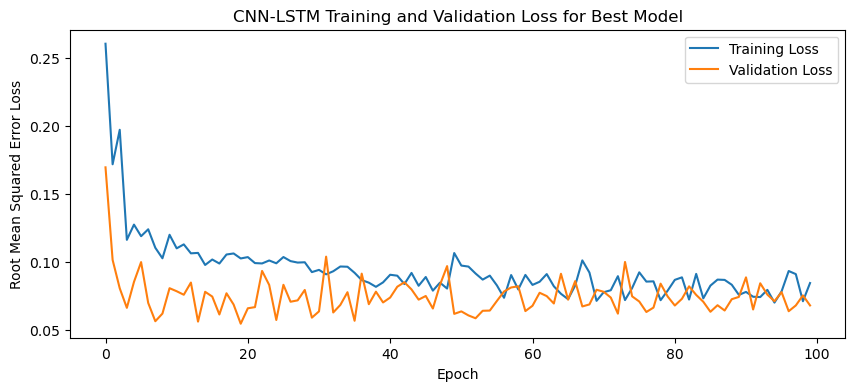

1/1 - 2s - loss: 0.1000 - 2s/epoch - 2s/step
Test Loss: 0.10004889965057373
Fold 2:
Epoch 1/100
19/19 [==============================] - 13s 285ms/step - loss: 0.2144 - val_loss: 0.1690
Epoch 2/100
19/19 [==============================] - 3s 163ms/step - loss: 0.1605 - val_loss: 0.1144
Epoch 3/100
19/19 [==============================] - 4s 207ms/step - loss: 0.1276 - val_loss: 0.1303
Epoch 4/100
19/19 [==============================] - 3s 151ms/step - loss: 0.1315 - val_loss: 0.1028
Epoch 5/100
19/19 [==============================] - 4s 199ms/step - loss: 0.1453 - val_loss: 0.0928
Epoch 6/100
19/19 [==============================] - 4s 211ms/step - loss: 0.1333 - val_loss: 0.1126
Epoch 7/100
19/19 [==============================] - 4s 234ms/step - loss: 0.1109 - val_loss: 0.0765
Epoch 8/100
19/19 [==============================] - 5s 232ms/step - loss: 0.1098 - val_loss: 0.1151
Epoch 9/100
19/19 [==============================] - 3s 175ms/step - loss: 0.1188 - val_loss: 0.1275
Epoch 

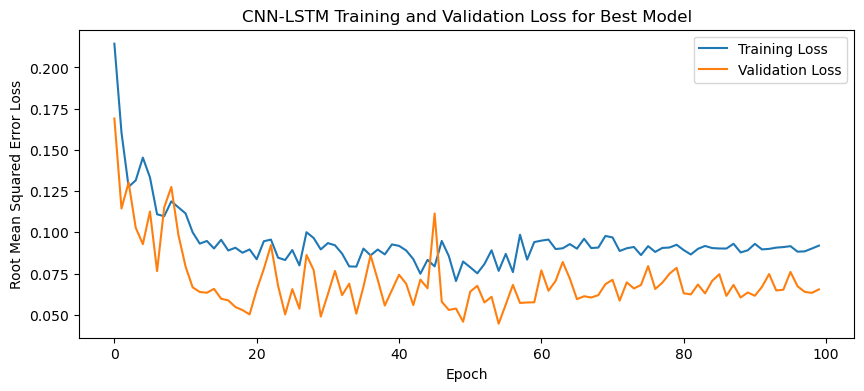

1/1 - 3s - loss: 0.0968 - 3s/epoch - 3s/step
Test Loss: 0.09684456884860992
Fold 3:
Epoch 1/100
19/19 [==============================] - 18s 471ms/step - loss: 0.2625 - val_loss: 0.1145
Epoch 2/100
19/19 [==============================] - 4s 205ms/step - loss: 0.1593 - val_loss: 0.0807
Epoch 3/100
19/19 [==============================] - 4s 184ms/step - loss: 0.1427 - val_loss: 0.1579
Epoch 4/100
19/19 [==============================] - 4s 201ms/step - loss: 0.1290 - val_loss: 0.0734
Epoch 5/100
19/19 [==============================] - 3s 168ms/step - loss: 0.1157 - val_loss: 0.0963
Epoch 6/100
19/19 [==============================] - 3s 167ms/step - loss: 0.1116 - val_loss: 0.0875
Epoch 7/100
19/19 [==============================] - 3s 157ms/step - loss: 0.1166 - val_loss: 0.1068
Epoch 8/100
19/19 [==============================] - 3s 158ms/step - loss: 0.1084 - val_loss: 0.0823
Epoch 9/100
19/19 [==============================] - 3s 170ms/step - loss: 0.1044 - val_loss: 0.0682
Epoch 

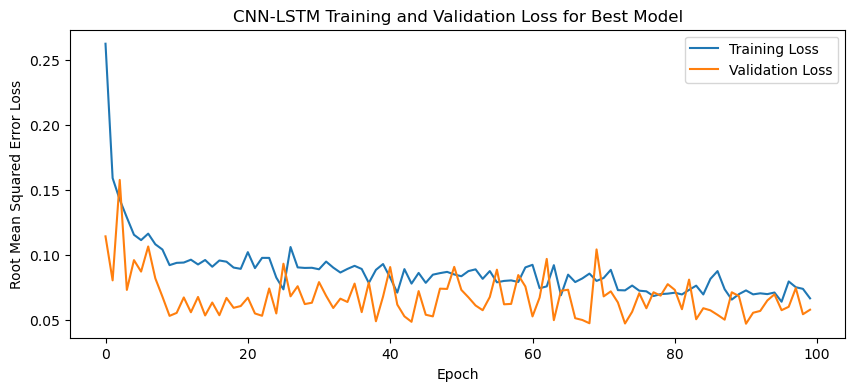

1/1 - 3s - loss: 0.0720 - 3s/epoch - 3s/step
Test Loss: 0.07199182361364365
Fold 4:
Epoch 1/100
20/20 [==============================] - 14s 288ms/step - loss: 0.2622 - val_loss: 0.2114
Epoch 2/100
20/20 [==============================] - 5s 240ms/step - loss: 0.1581 - val_loss: 0.2025
Epoch 3/100
20/20 [==============================] - 3s 164ms/step - loss: 0.1185 - val_loss: 0.2160
Epoch 4/100
20/20 [==============================] - 3s 150ms/step - loss: 0.1204 - val_loss: 0.1073
Epoch 5/100
20/20 [==============================] - 3s 162ms/step - loss: 0.1170 - val_loss: 0.1792
Epoch 6/100
20/20 [==============================] - 3s 145ms/step - loss: 0.1161 - val_loss: 0.1493
Epoch 7/100
20/20 [==============================] - 2s 121ms/step - loss: 0.1071 - val_loss: 0.1912
Epoch 8/100
20/20 [==============================] - 2s 125ms/step - loss: 0.1117 - val_loss: 0.1129
Epoch 9/100
20/20 [==============================] - 2s 114ms/step - loss: 0.1040 - val_loss: 0.1223
Epoch 

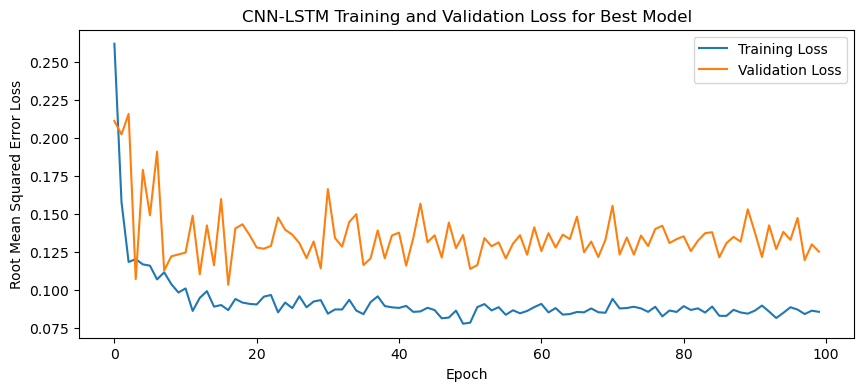

1/1 - 4s - loss: 0.0823 - 4s/epoch - 4s/step
Test Loss: 0.08225991576910019
Fold 5:
Epoch 1/100
19/19 [==============================] - 24s 424ms/step - loss: 0.2737 - val_loss: 0.1117
Epoch 2/100
19/19 [==============================] - 3s 179ms/step - loss: 0.1426 - val_loss: 0.2652
Epoch 3/100
19/19 [==============================] - 4s 214ms/step - loss: 0.1379 - val_loss: 0.2187
Epoch 4/100
19/19 [==============================] - 4s 197ms/step - loss: 0.1264 - val_loss: 0.1322
Epoch 5/100
19/19 [==============================] - 5s 239ms/step - loss: 0.1040 - val_loss: 0.1352
Epoch 6/100
19/19 [==============================] - 4s 196ms/step - loss: 0.1071 - val_loss: 0.1313
Epoch 7/100
19/19 [==============================] - 4s 212ms/step - loss: 0.1021 - val_loss: 0.1631
Epoch 8/100
19/19 [==============================] - 4s 192ms/step - loss: 0.0979 - val_loss: 0.1792
Epoch 9/100
19/19 [==============================] - 2s 124ms/step - loss: 0.0881 - val_loss: 0.1514
Epoch 

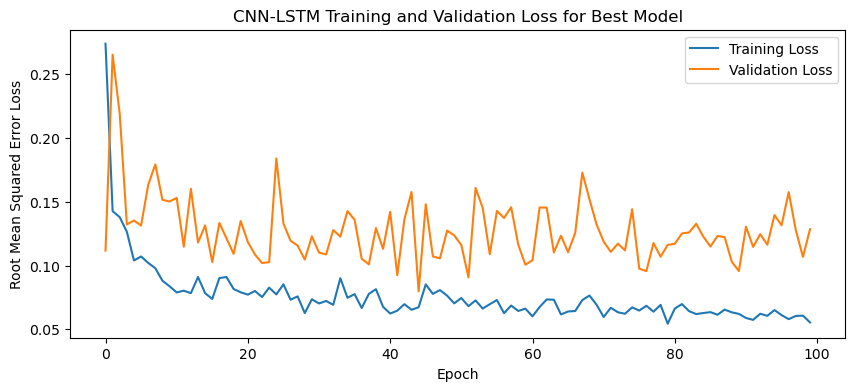

1/1 - 3s - loss: 0.0679 - 3s/epoch - 3s/step
Test Loss: 0.06790004670619965


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

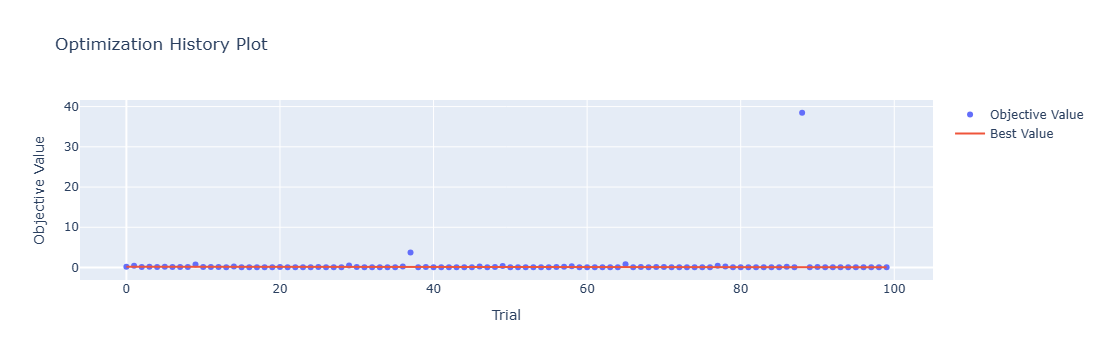

In [4]:
optuna.visualization.plot_optimization_history(study)

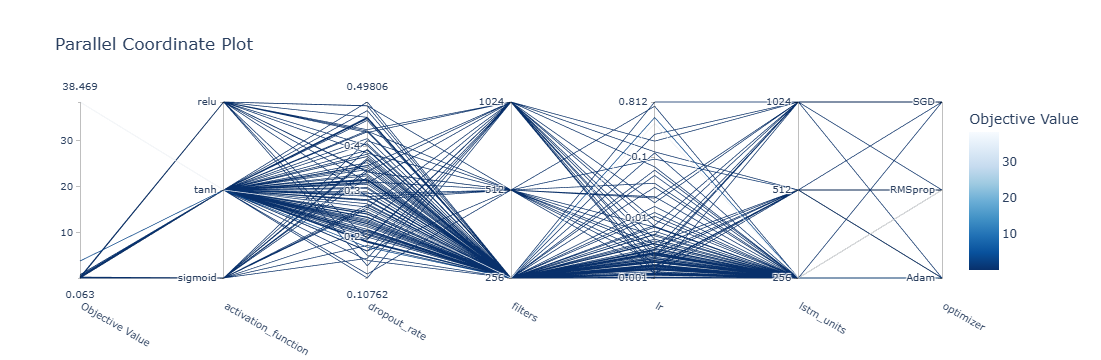

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

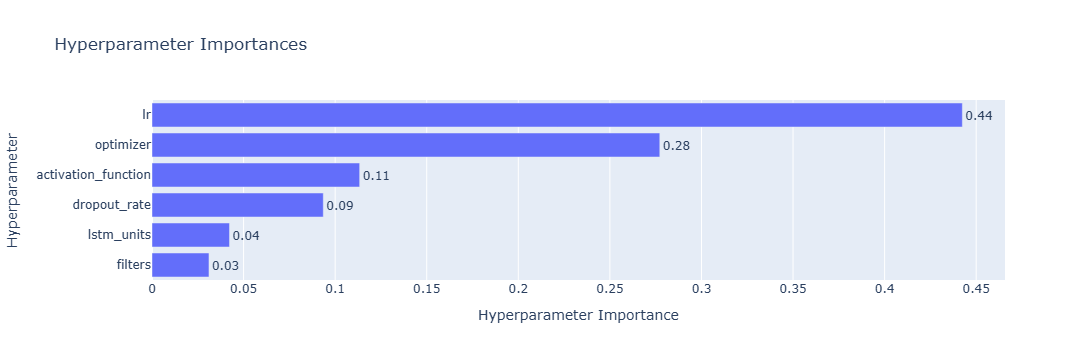

In [6]:
optuna.visualization.plot_param_importances(study)

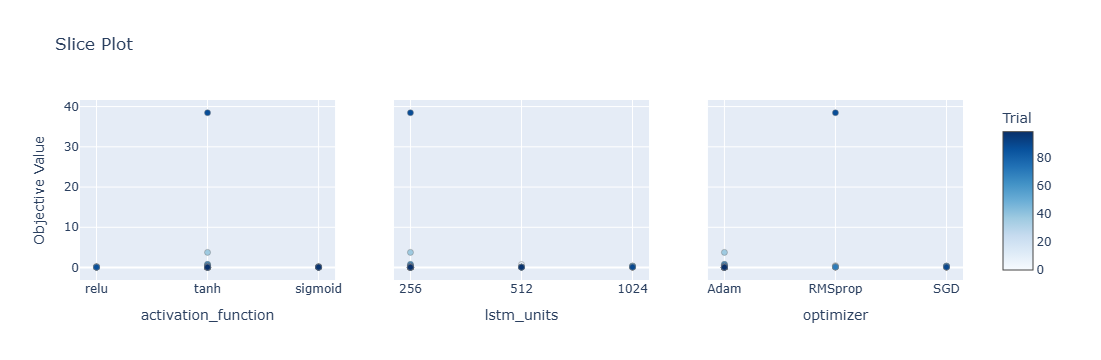

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

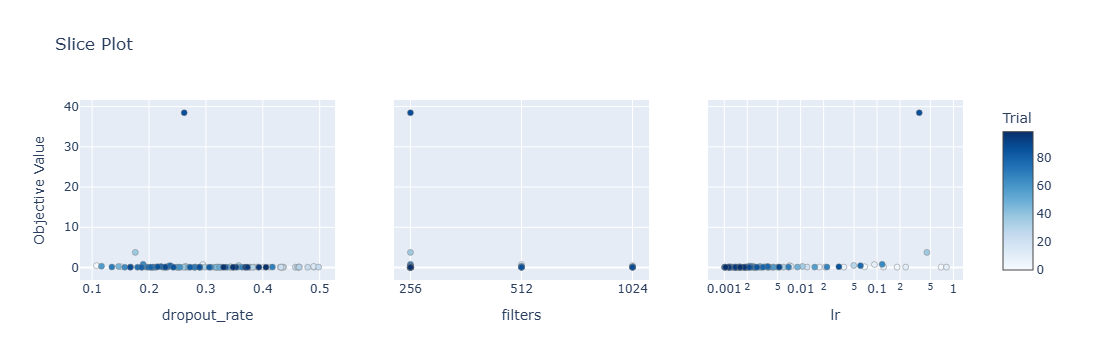

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 25s 340ms/step - loss: 0.2216 - accuracy: 0.4737 - mae: 0.1966 - rmse: 0.2216 - mape: 35.6015 - pearson: 0.3715 - val_loss: 0.1553 - val_accuracy: 0.6667 - val_mae: 0.1420 - val_rmse: 0.1553 - val_mape: 26.8762 - val_pearson: 0.2494
Epoch 2/100
19/19 [==============================] - 2s 123ms/step - loss: 0.1757 - accuracy: 0.1053 - mae: 0.1518 - rmse: 0.1757 - mape: 27.9926 - pearson: 0.2608 - val_loss: 0.1249 - val_accuracy: 0.3333 - val_mae: 0.1060 - val_rmse: 0.1249 - val_mape: 18.7720 - val_pearson: 0.0863
Epoch 3/100
19/19 [==============================] - 2s 117ms/step - loss: 0.1556 - accura

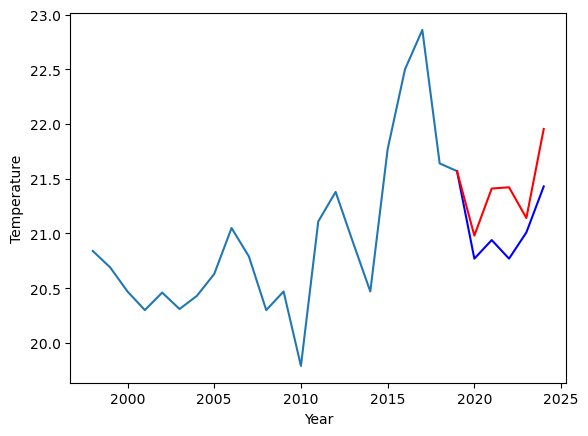

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.52		16.71		-0.81
16.69		17.14		0.45
16.18		17.15		0.97
16.46		16.87		0.41
16.29		17.69		1.40


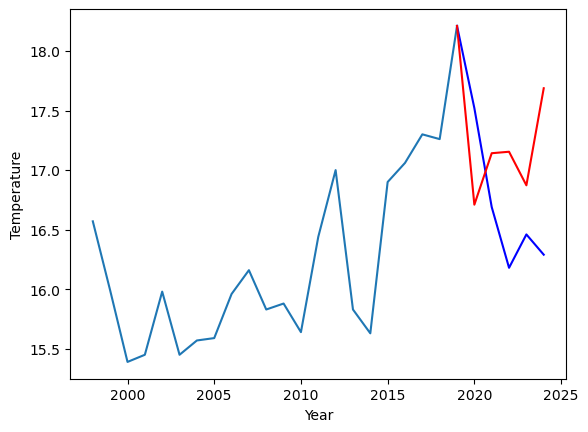

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.77  20.980495
1                1   17.52  16.709687


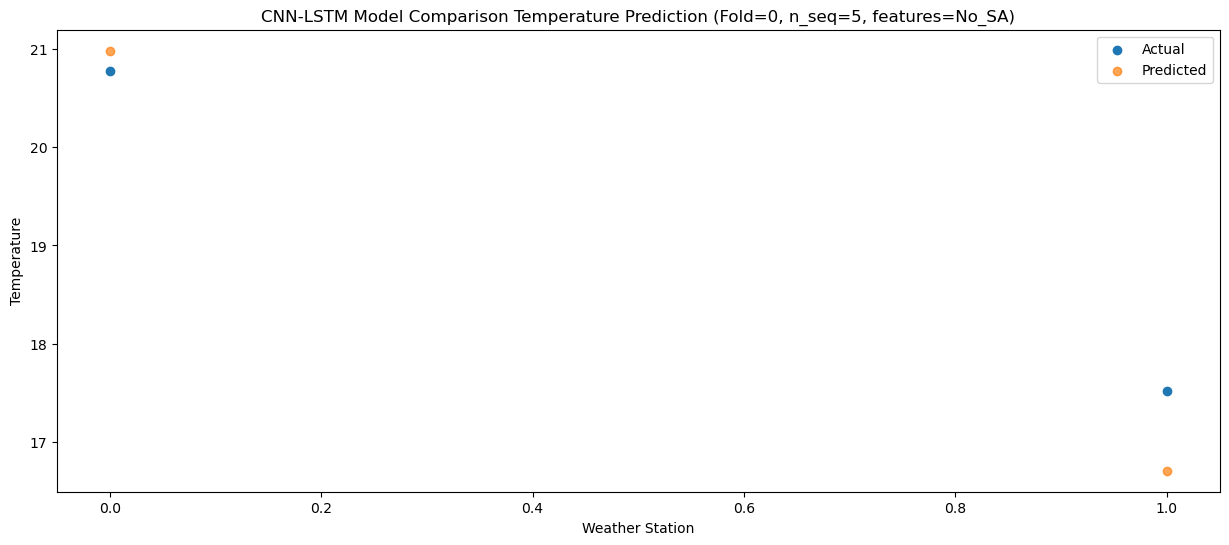

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.94  21.410737
1                1   16.69  17.141634


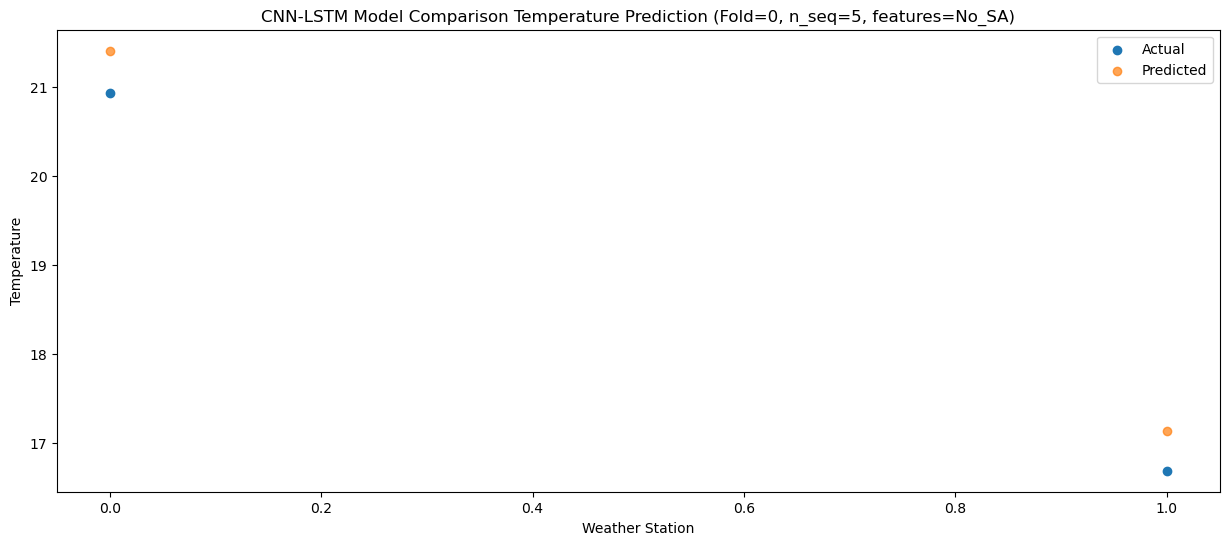

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.77  21.422157
1                1   16.18  17.154013


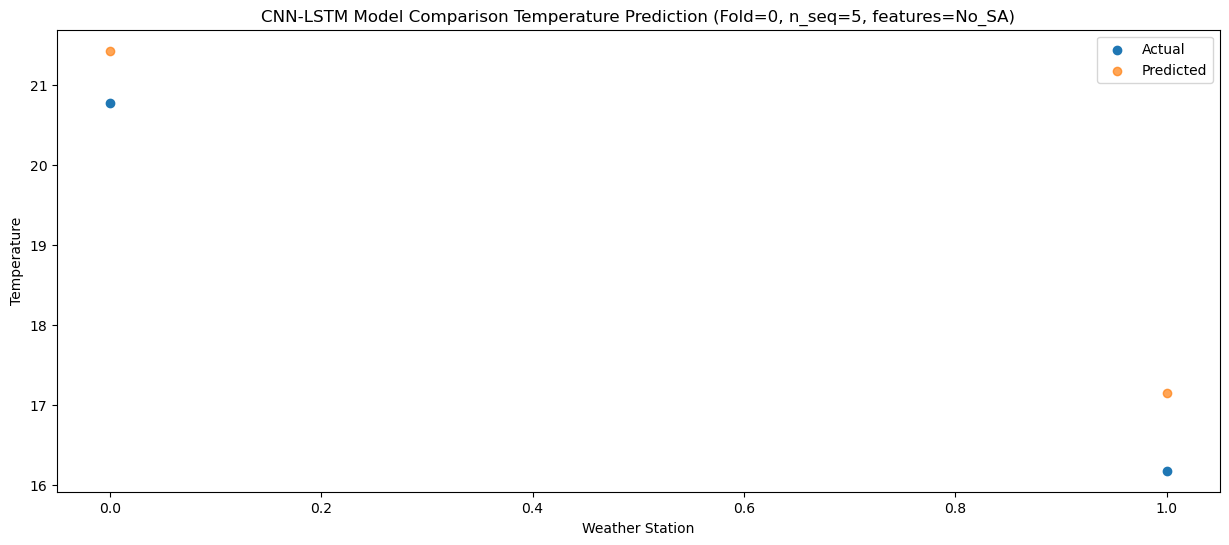

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.01  21.141371
1                1   16.46  16.872295


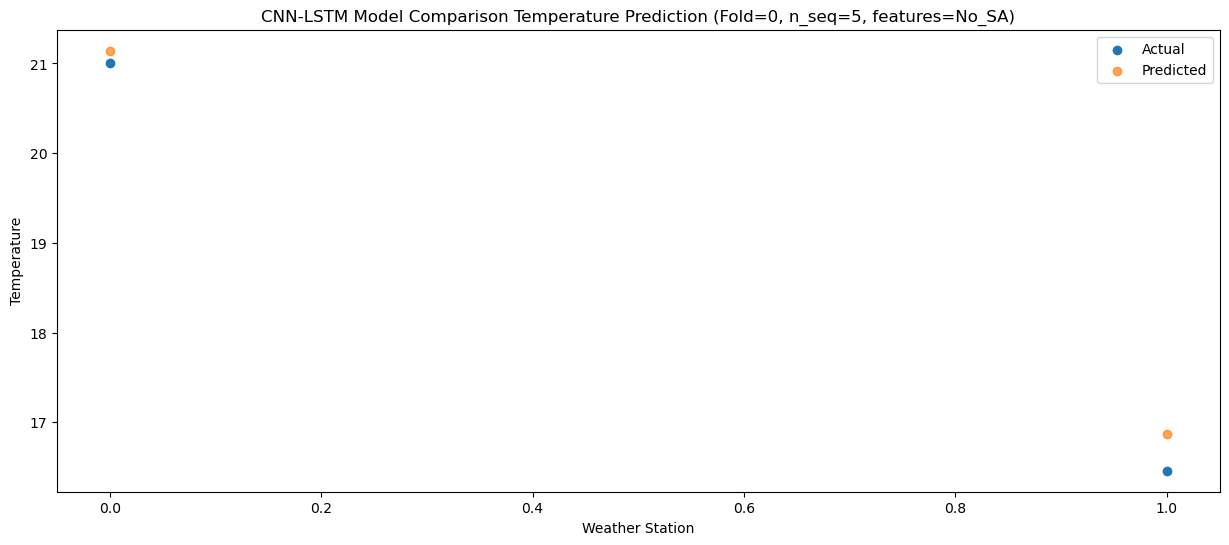

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.43  21.955130
1                1   16.29  17.686954


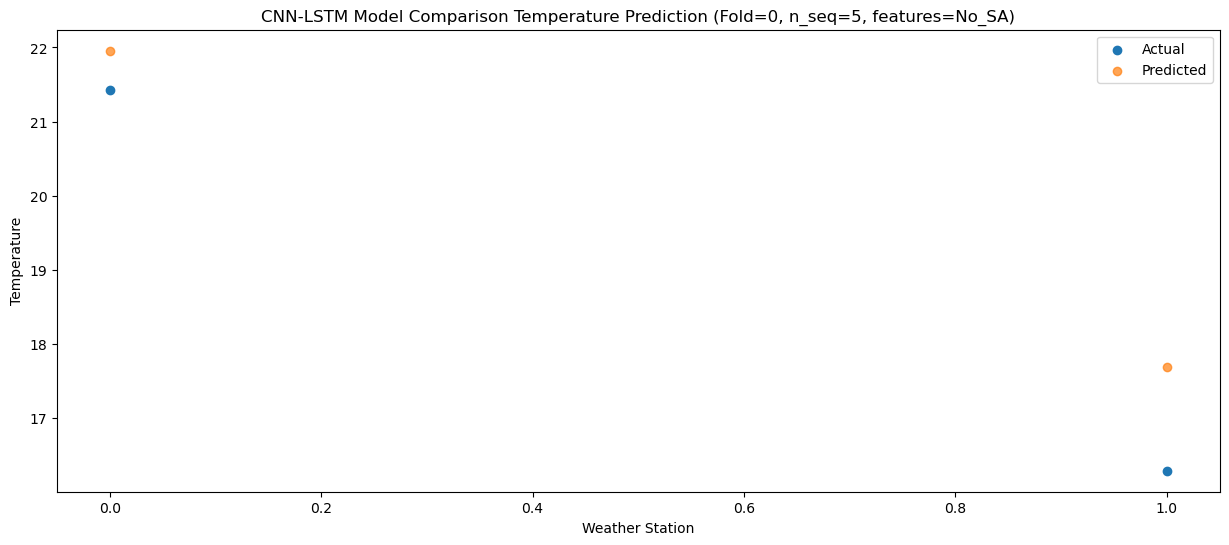

f, t:
[[20.77 17.52]
 [20.94 16.69]
 [20.77 16.18]
 [21.01 16.46]
 [21.43 16.29]]
[[20.98049453 16.70968652]
 [21.41073671 17.14163441]
 [21.42215732 17.15401331]
 [21.14137057 16.8722949 ]
 [21.95513049 17.68695402]]
Year at t+1:
t+1 SKRMSE: 0.591995
t+1 KRMSE: 0.591995
t+1 MAE: 0.510404
t+1 SKMAPE: 0.028193
t+1 R2_SCORE: 0.867282
t+1 KMAPE: 0.028193
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.461284
t+2 KRMSE: 0.461284
t+2 MAE: 0.461186
t+2 SKMAPE: 0.024770
t+2 R2_SCORE: 0.952878
t+2 KMAPE: 0.024770
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.828858
t+3 KRMSE: 0.828858
t+3 MAE: 0.813085
t+3 SKMAPE: 0.045799
t+3 R2_SCORE: 0.869565
t+3 KMAPE: 0.045799
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.305978
t+4 KRMSE: 0.305978
t+4 MAE: 0.271833
t+4 SKMAPE: 0.015651
t+4 R2_SCORE: 0.981911
t+4 KMAPE: 0.015651
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.055283
t+5 KRMSE: 1.055283
t+5 MAE: 0.961042
t+5 SKMAPE: 0.055130
t+5 R2_SCORE: 0.831395
t+5 KMAPE: 0.055130
t+5 PEARSON: 1

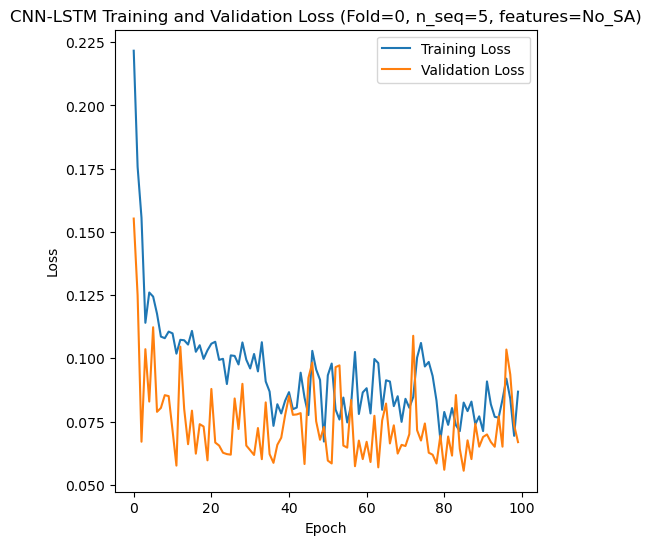

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 27s 382ms/step - loss: 0.2470 - accuracy: 0.2105 - mae: 0.2207 - rmse: 0.2470 - mape: 36.0408 - pearson: 0.2966 - val_loss: 0.2248 - val_accuracy: 1.0000 - val_mae: 0.1881 - val_rmse: 0.2248 - val_mape: 30.0266 - val_pearson: 0.4971
Epoch 2/100
19/19 [==============================] - 2s 110ms/step - loss: 0.1683 - accuracy: 0.3158 - mae: 0.1482 - rmse: 0.1683 - mape: 23.7841 - pearson: 0.3990 - val_loss: 0.1243 - val_accuracy: 0.0000e+00 - val_mae: 0.1014 - val_rmse: 0.1243 - val_mape: 15.2436 - val_pearson: 0.5514
Epoch 3/100
19/19 [==============================] - 2s 126ms/step - loss: 0.1399 - acc

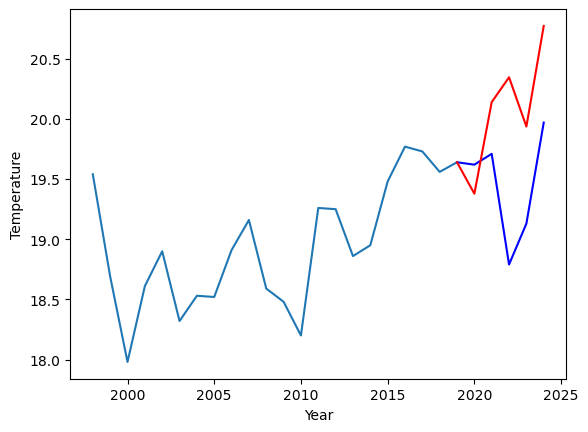

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.82		19.53		-0.29
20.34		20.29		-0.05
19.95		20.50		0.55
19.95		20.09		0.14
21.26		20.93		-0.33


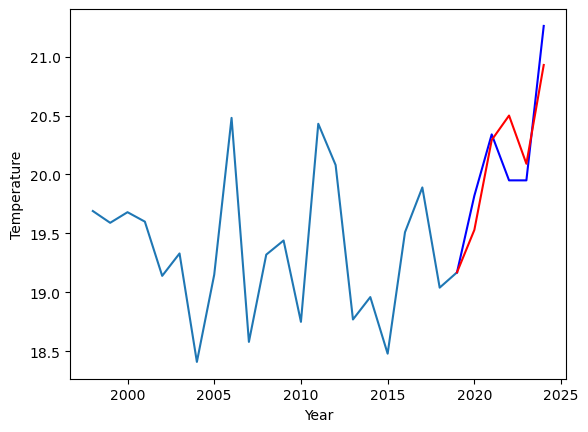

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.62  19.378829
1                1   19.82  19.529809


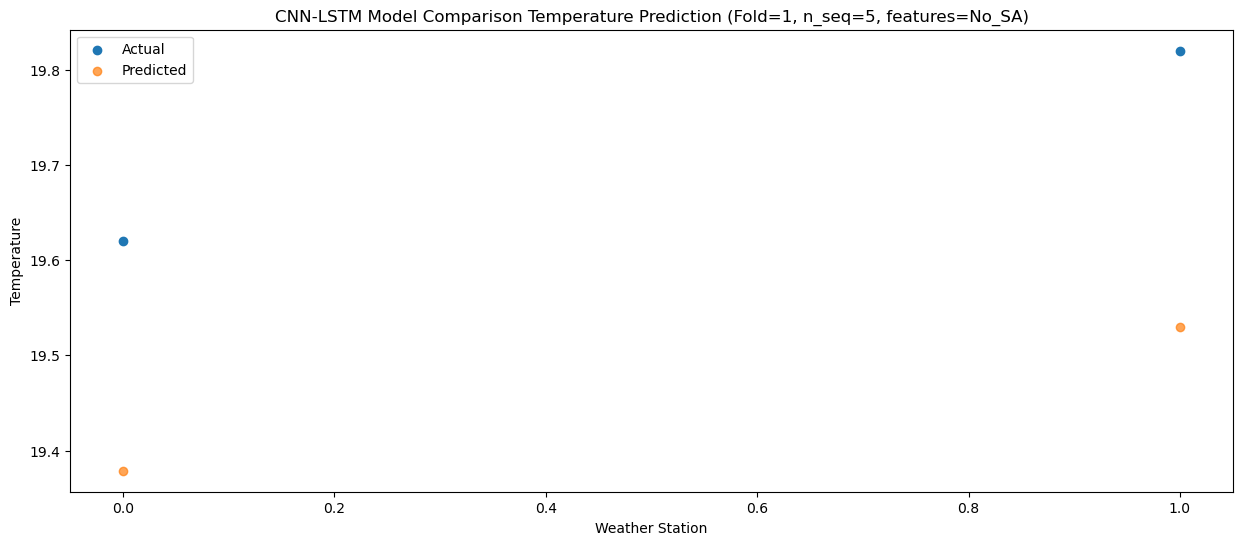

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   19.71  20.139938
1                1   20.34  20.291937


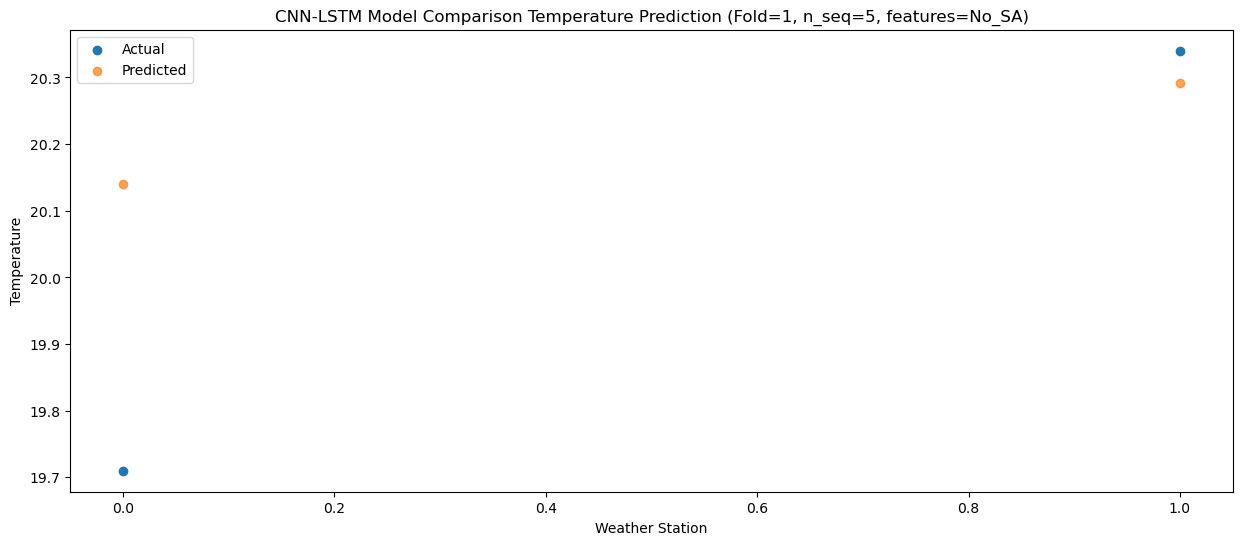

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.79  20.346602
1                1   19.95  20.499701


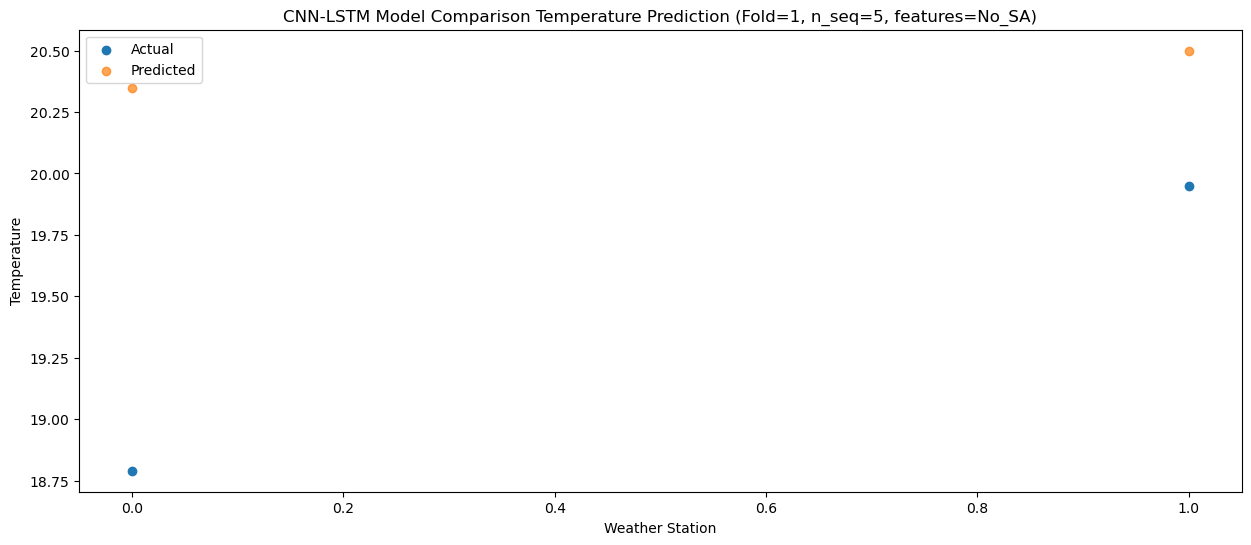

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   19.13  19.936719
1                1   19.95  20.090839


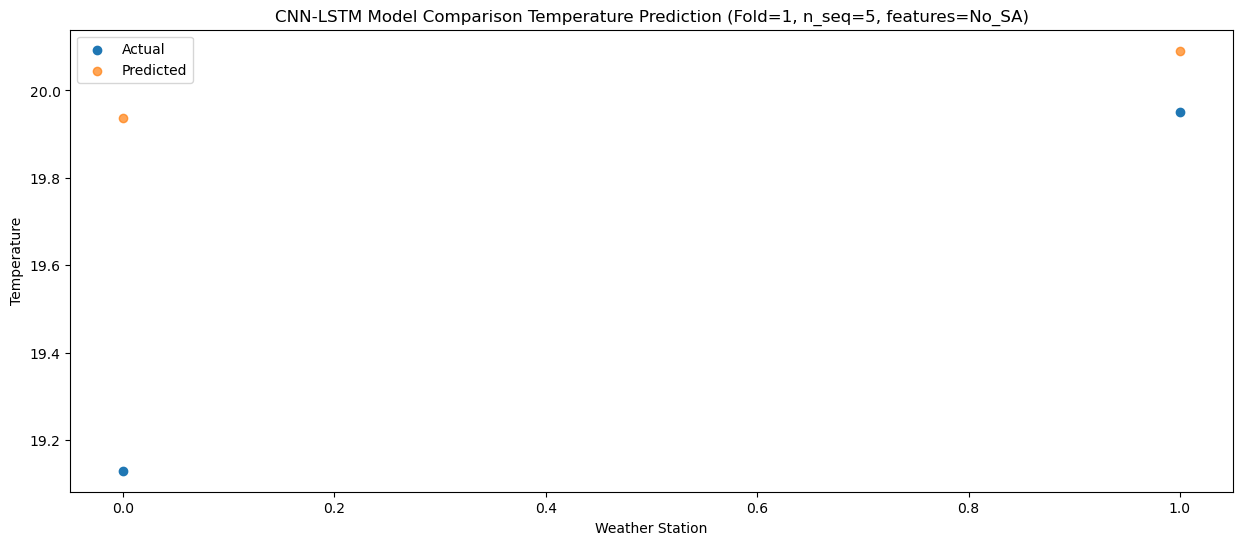

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   19.97  20.773573
1                1   21.26  20.928776


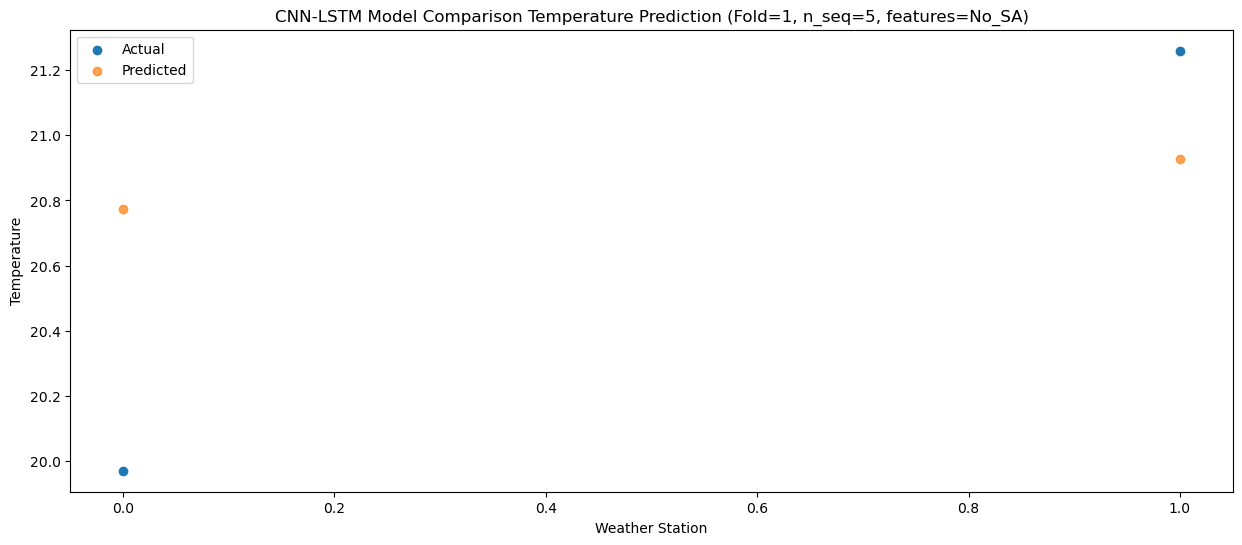

f, t:
[[19.62 19.82]
 [19.71 20.34]
 [18.79 19.95]
 [19.13 19.95]
 [19.97 21.26]]
[[19.37882877 19.52980942]
 [20.13993771 20.29193676]
 [20.34660206 20.49970094]
 [19.93671898 20.09083921]
 [20.77357296 20.92877621]]
Year at t+1:
t+1 SKRMSE: 0.266809
t+1 KRMSE: 0.266809
t+1 MAE: 0.265681
t+1 SKMAPE: 0.013467
t+1 R2_SCORE: -6.118707
t+1 KMAPE: 0.013467
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.305906
t+2 KRMSE: 0.305906
t+2 MAE: 0.239000
t+2 SKMAPE: 0.012088
t+2 R2_SCORE: 0.056909
t+2 KMAPE: 0.012088
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.167301
t+3 KRMSE: 1.167301
t+3 MAE: 1.053151
t+3 SKMAPE: 0.055198
t+3 R2_SCORE: -3.050507
t+3 KMAPE: 0.055198
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.579064
t+4 KRMSE: 0.579064
t+4 MAE: 0.473779
t+4 SKMAPE: 0.024615
t+4 R2_SCORE: -0.994739
t+4 KMAPE: 0.024615
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.614589
t+5 KRMSE: 0.614589
t+5 MAE: 0.567398
t+5 SKMAPE: 0.027909
t+5 R2_SCORE: 0.092075
t+5 KMAPE: 0.027909
t+5 PEARSON

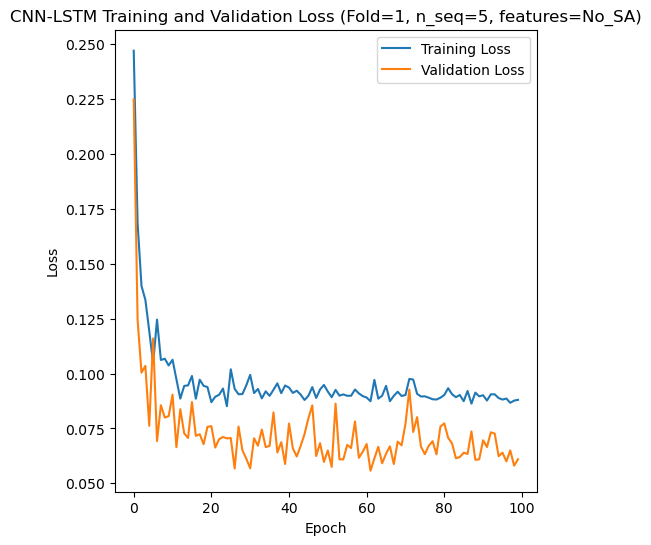

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 30s 371ms/step - loss: 0.2420 - accuracy: 0.3684 - mae: 0.2183 - rmse: 0.2420 - mape: 35.2308 - pearson: 0.3238 - val_loss: 0.1566 - val_accuracy: 0.0000e+00 - val_mae: 0.1320 - val_rmse: 0.1566 - val_mape: 20.7667 - val_pearson: 0.1203
Epoch 2/100
19/19 [==============================] - 3s 135ms/step - loss: 0.1439 - accuracy: 0.4737 - mae: 0.1245 - rmse: 0.1439 - mape: 20.9501 - pearson: 0.3351 - val_loss: 0.1272 - val_accuracy: 0.3333 - val_mae: 0.1031 - val_rmse: 0.1272 - val_mape: 17.8860 - val_pearson: 0.1170
Epoch 3/100
19/19 [==============================] - 3s 138ms/step - loss: 0.1335 - acc

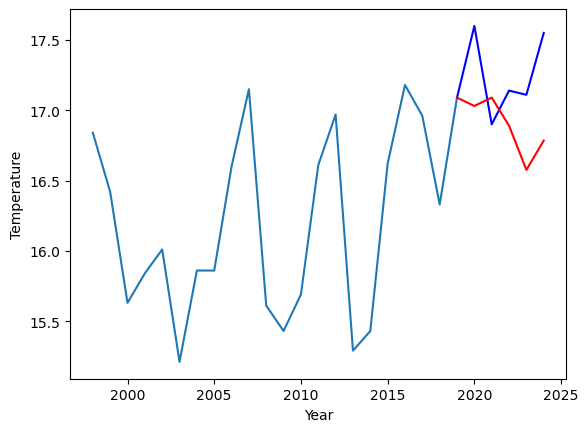

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.84		13.47		-0.37
13.83		13.81		-0.02
13.82		13.73		-0.09
13.36		13.05		-0.31
14.15		13.35		-0.80


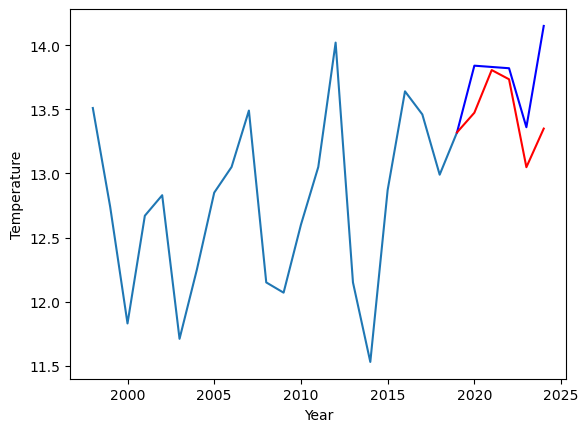

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.60  17.030630
1                1   13.84  13.473086


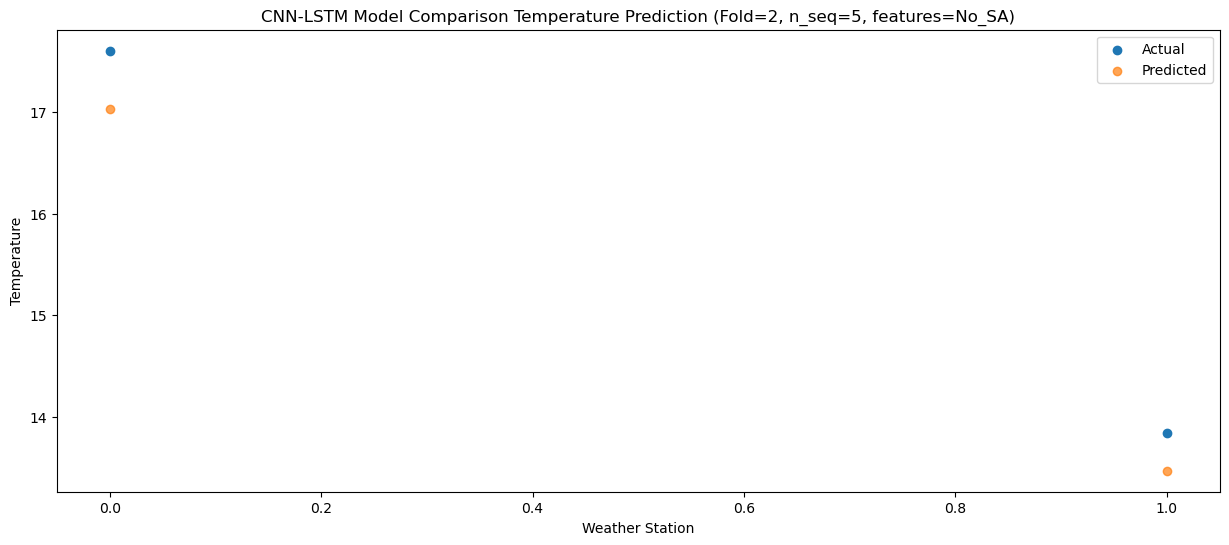

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   16.90  17.090170
1                1   13.83  13.805839


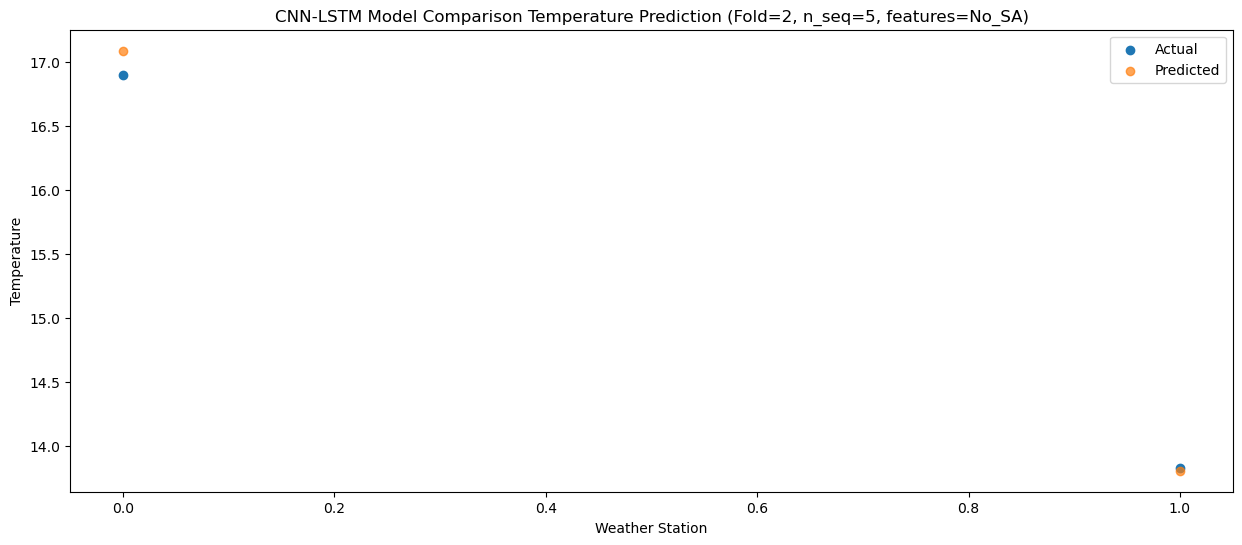

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   17.14  16.890298
1                1   13.82  13.733898


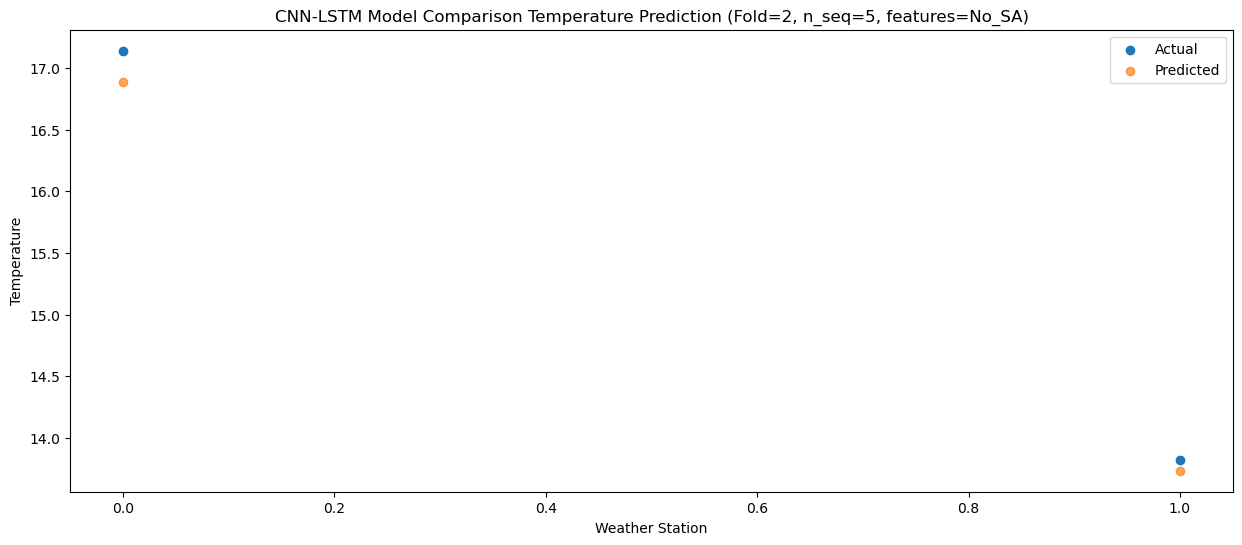

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   17.11  16.575779
1                1   13.36  13.048339


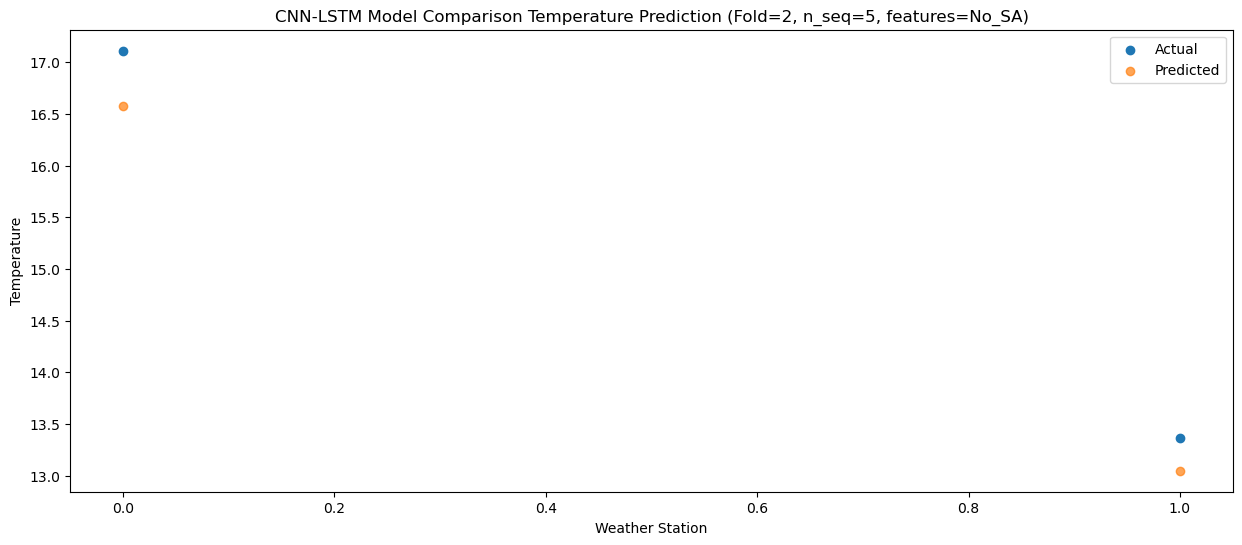

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.55  16.784172
1                1   14.15  13.349354


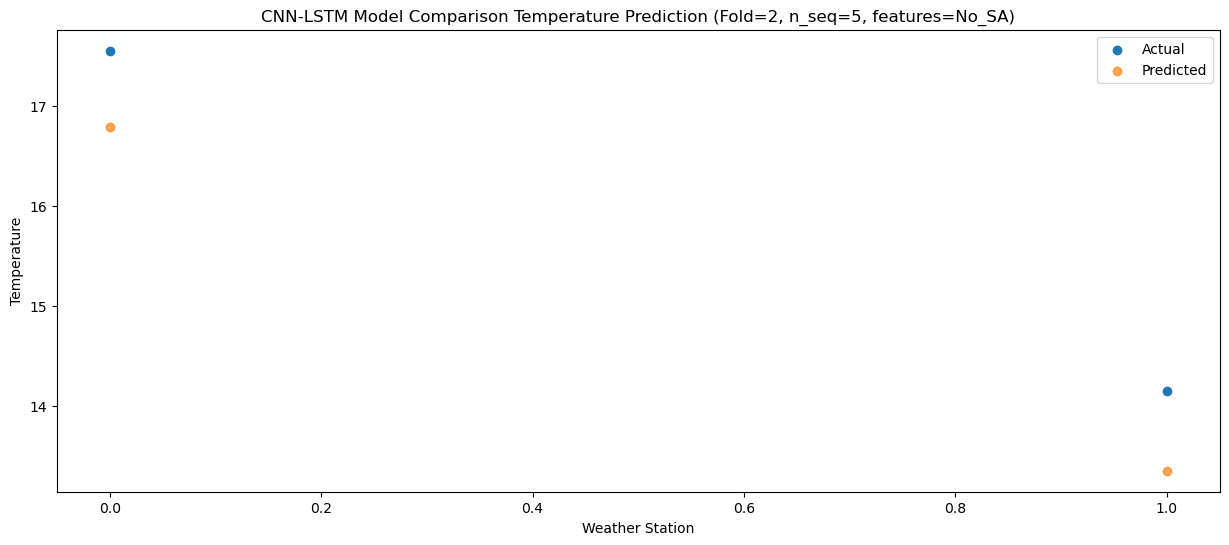

f, t:
[[17.6  13.84]
 [16.9  13.83]
 [17.14 13.82]
 [17.11 13.36]
 [17.55 14.15]]
[[17.03063039 13.47308609]
 [17.09016958 13.80583939]
 [16.89029753 13.73389755]
 [16.57577946 13.04833935]
 [16.7841718  13.34935369]]
Year at t+1:
t+1 SKRMSE: 0.478961
t+1 KRMSE: 0.478961
t+1 MAE: 0.468142
t+1 SKMAPE: 0.029431
t+1 R2_SCORE: 0.935094
t+1 KMAPE: 0.029431
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.135551
t+2 KRMSE: 0.135551
t+2 MAE: 0.107165
t+2 SKMAPE: 0.006500
t+2 R2_SCORE: 0.992202
t+2 KMAPE: 0.006500
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.186769
t+3 KRMSE: 0.186769
t+3 MAE: 0.167902
t+3 SKMAPE: 0.010399
t+3 R2_SCORE: 0.987341
t+3 KMAPE: 0.010399
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.437335
t+4 KRMSE: 0.437335
t+4 MAE: 0.422941
t+4 SKMAPE: 0.027275
t+4 R2_SCORE: 0.945597
t+4 KMAPE: 0.027275
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.783431
t+5 KRMSE: 0.783431
t+5 MAE: 0.783237
t+5 SKMAPE: 0.050110
t+5 R2_SCORE: 0.787625
t+5 KMAPE: 0.050110
t+5 PEARSON: 1

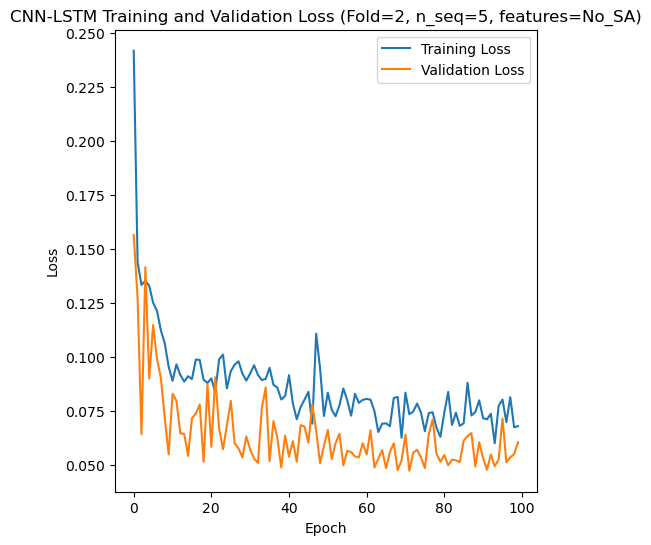

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 25s 404ms/step - loss: 0.2900 - accuracy: 0.2000 - mae: 0.2580 - rmse: 0.2900 - mape: 39.6900 - pearson: 0.3367 - val_loss: 0.2306 - val_accuracy: 0.5000 - val_mae: 0.1942 - val_rmse: 0.2306 - val_mape: 25.6260 - val_pearson: 0.2743
Epoch 2/100
20/20 [==============================] - 3s 146ms/step - loss: 0.1466 - accuracy: 0.4000 - mae: 0.1282 - rmse: 0.1466 - mape: 19.6746 - pearson: 0.3628 - val_loss: 0.1510 - val_accuracy: 0.5000 - val_mae: 0.1364 - val_rmse: 0.1510 - val_mape: 20.3118 - val_pearson: 0.7397
Epoch 3/100
20/20 [==============================] - 2s 126ms/step - loss: 0.1445 - accuracy

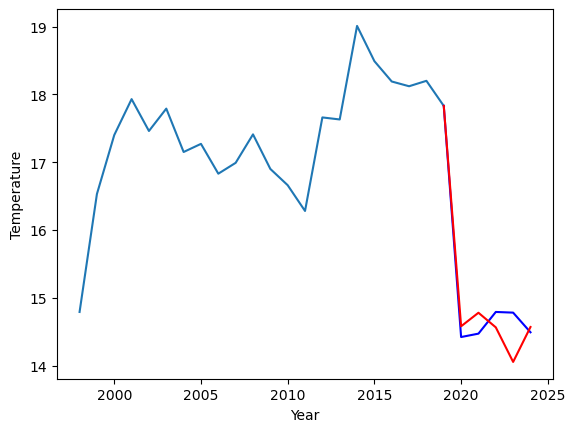

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.47		13.92		-0.55
14.35		14.03		-0.32
14.15		13.77		-0.38
13.85		13.35		-0.50
14.87		13.85		-1.02


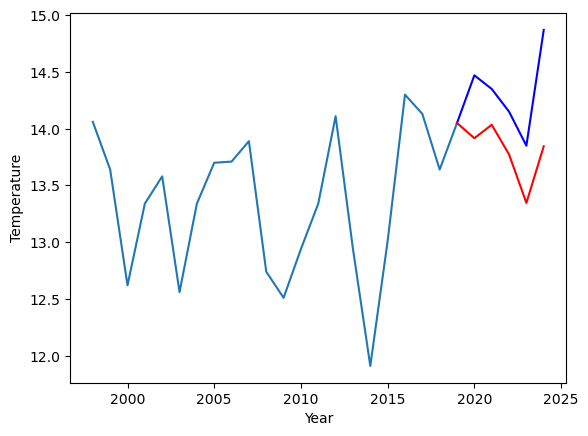

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   14.42  14.578736
1                1   14.47  13.915873


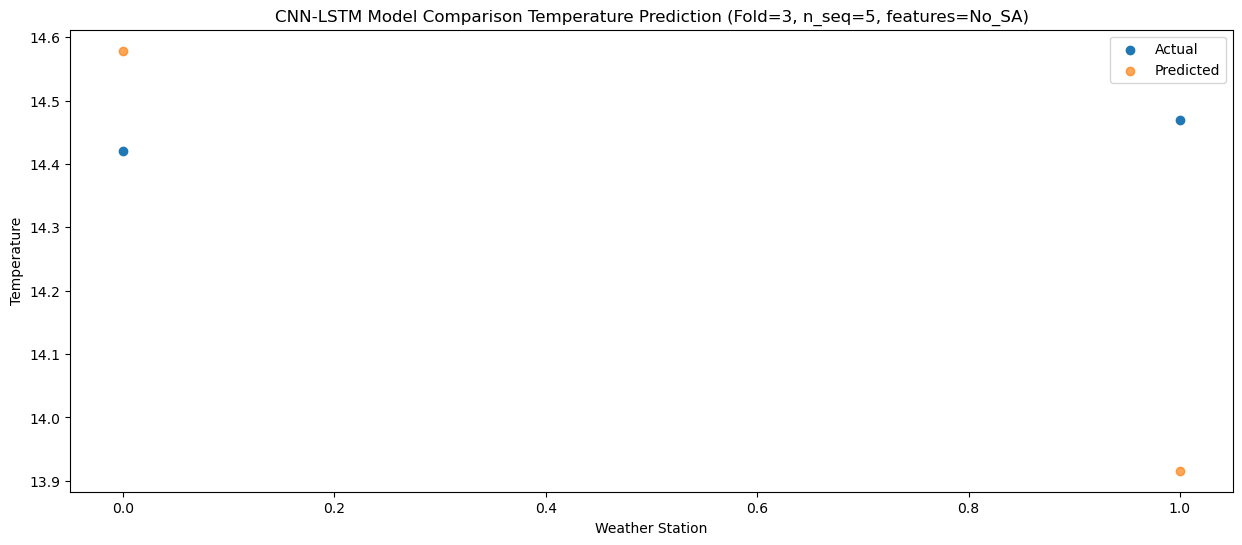

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   14.47  14.778330
1                1   14.35  14.034334


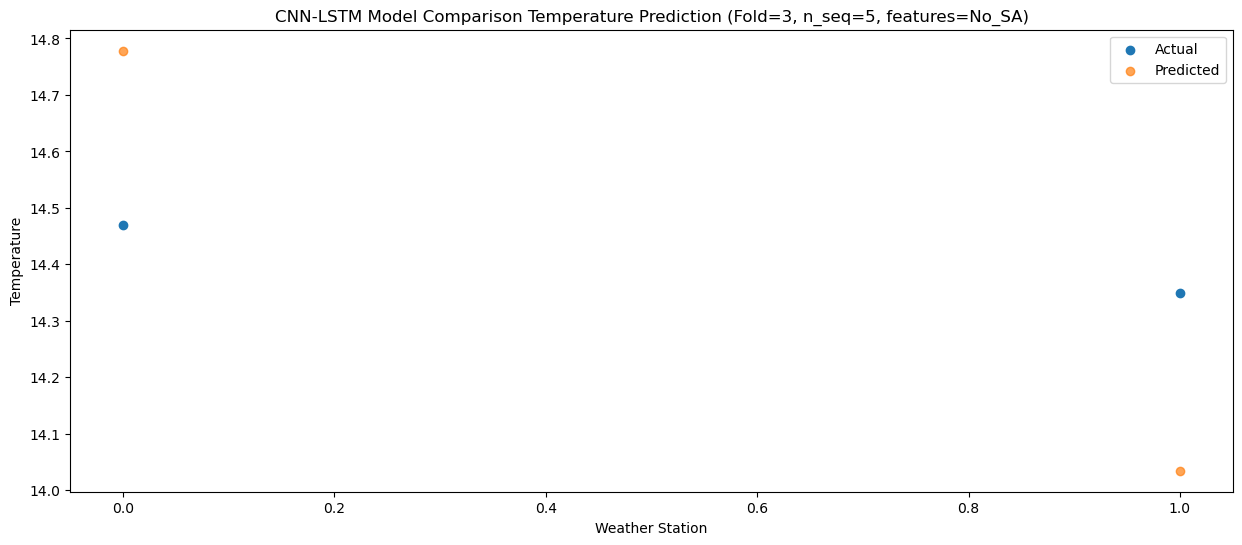

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   14.79  14.562787
1                1   14.15  13.773205


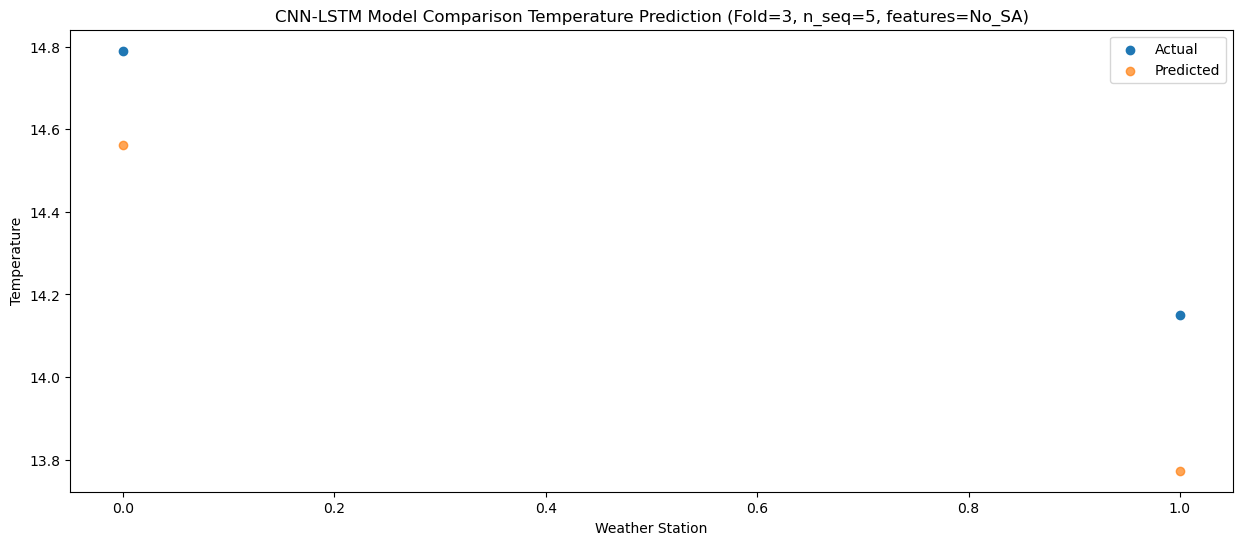

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.78  14.052792
1                1   13.85  13.345809


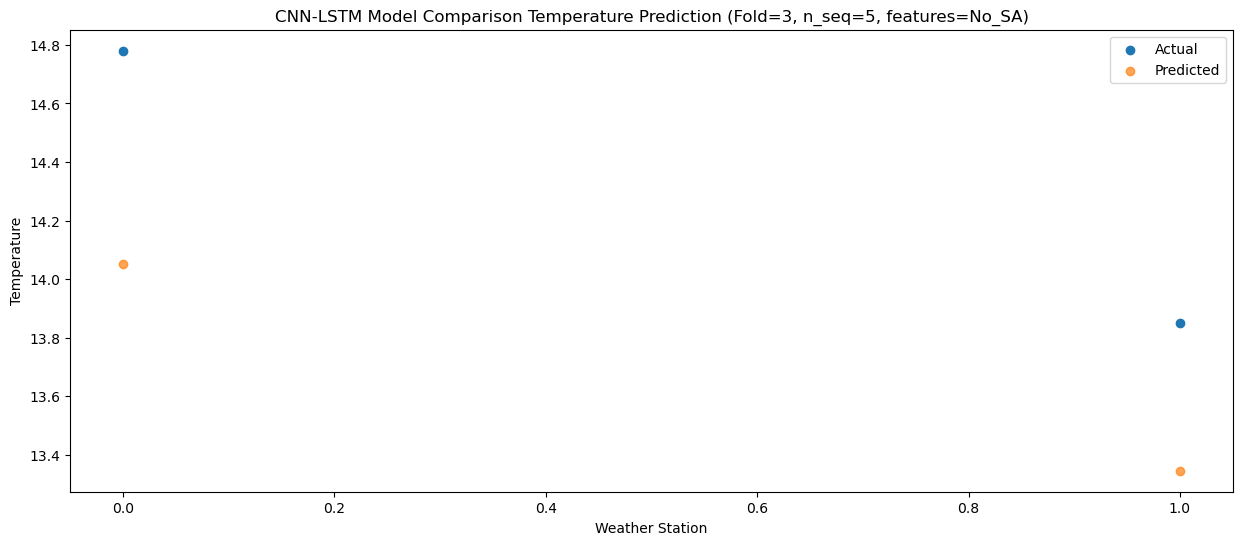

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   14.49  14.568106
1                1   14.87  13.845083


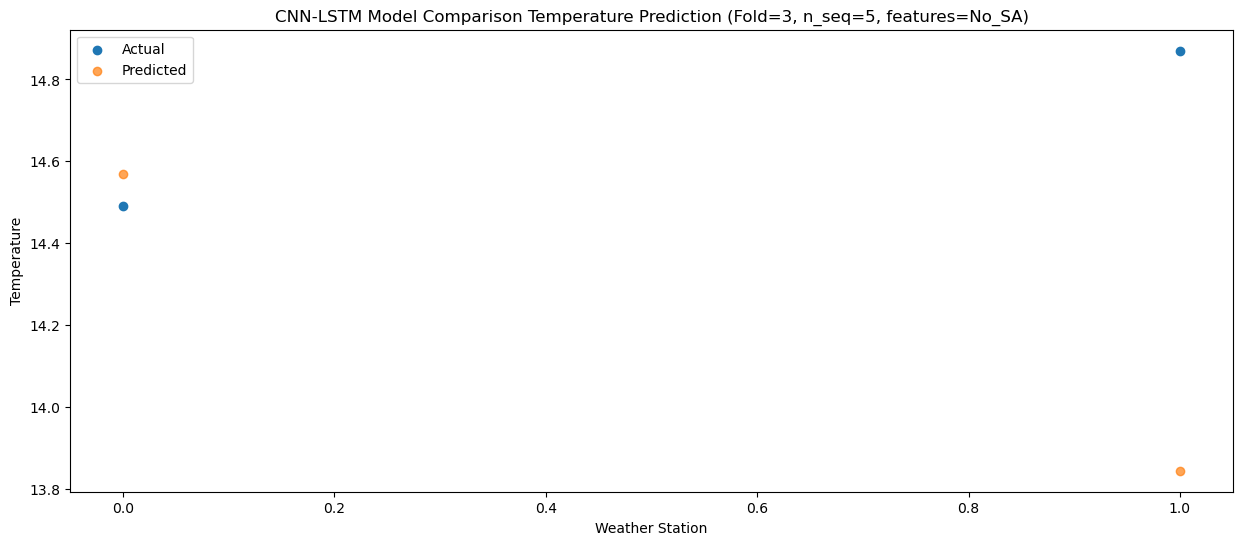

f, t:
[[14.42 14.47]
 [14.47 14.35]
 [14.79 14.15]
 [14.78 13.85]
 [14.49 14.87]]
[[14.5787361  13.91587272]
 [14.77833007 14.03433425]
 [14.56278689 13.77320488]
 [14.05279214 13.34580858]
 [14.56810559 13.84508304]]
Year at t+1:
t+1 SKRMSE: 0.407587
t+1 KRMSE: 0.407587
t+1 MAE: 0.356432
t+1 SKMAPE: 0.024651
t+1 R2_SCORE: -264.803354
t+1 KMAPE: 0.024651
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.312019
t+2 KRMSE: 0.312019
t+2 MAE: 0.311998
t+2 SKMAPE: 0.021653
t+2 R2_SCORE: -26.043374
t+2 KMAPE: 0.021653
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.311127
t+3 KRMSE: 0.311127
t+3 MAE: 0.302004
t+3 SKMAPE: 0.020996
t+3 R2_SCORE: 0.054686
t+3 KMAPE: 0.020996
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.625716
t+4 KRMSE: 0.625716
t+4 MAE: 0.615700
t+4 SKMAPE: 0.042803
t+4 R2_SCORE: -0.810707
t+4 KMAPE: 0.042803
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.726827
t+5 KRMSE: 0.726827
t+5 MAE: 0.551511
t+5 SKMAPE: 0.037158
t+5 R2_SCORE: -13.633729
t+5 KMAPE: 0.037158
t+5 PE

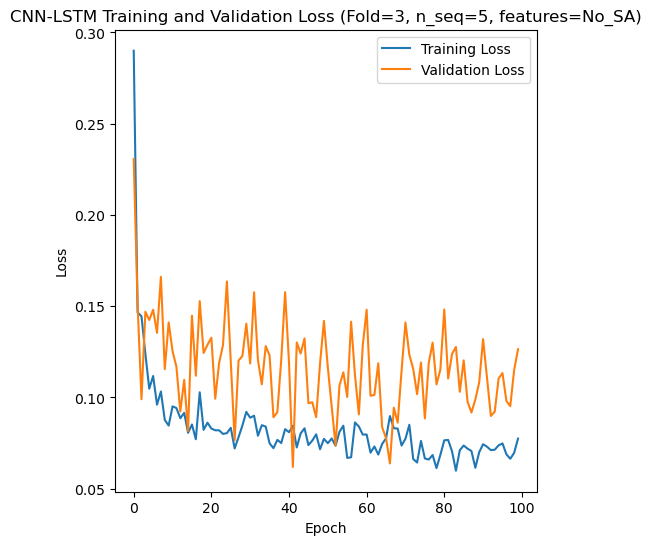

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 26s 353ms/step - loss: 0.2491 - accuracy: 0.1579 - mae: 0.2236 - rmse: 0.2491 - mape: 36.2184 - pearson: 0.2534 - val_loss: 0.0888 - val_accuracy: 0.0000e+00 - val_mae: 0.0682 - val_rmse: 0.0888 - val_mape: 10.6024 - val_pearson: 0.7963
Epoch 2/100
19/19 [==============================] - 2s 120ms/step - loss: 0.1353 - accuracy: 0.3158 - mae: 0.1163 - rmse: 0.1353 - mape: 18.7842 - pearson: 0.1853 - val_loss: 0.1278 - val_accuracy: 1.0000 - val_mae: 0.1126 - val_rmse: 0.1278 - val_mape: 20.0244 - val_pearson: 0.8517
Epoch 3/100
19/19 [==============================] - 2s 128ms/step - loss: 0.1215 - ac

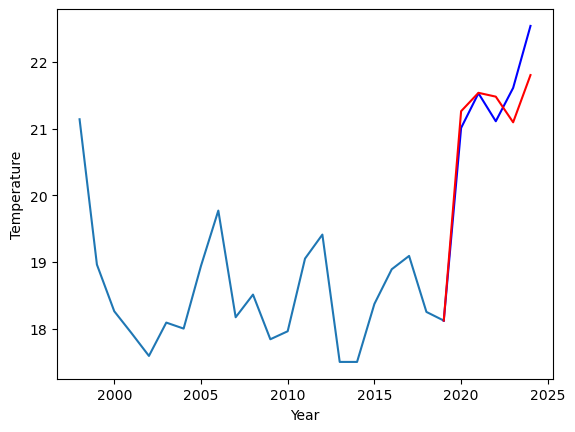

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.23		12.91		0.68
12.79		13.43		0.64
13.11		13.53		0.42
12.24		12.89		0.65
13.72		13.83		0.11


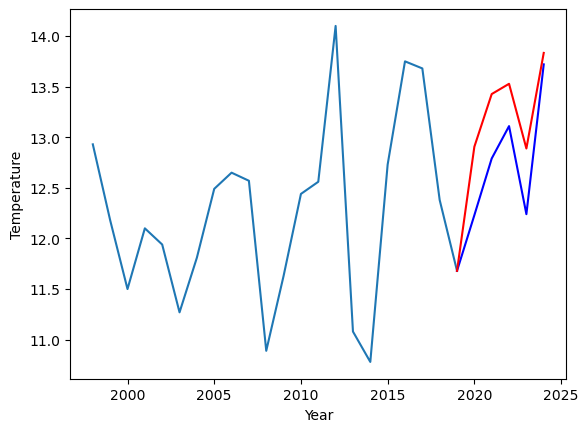

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.01  21.260847
1                1   12.23  12.906321


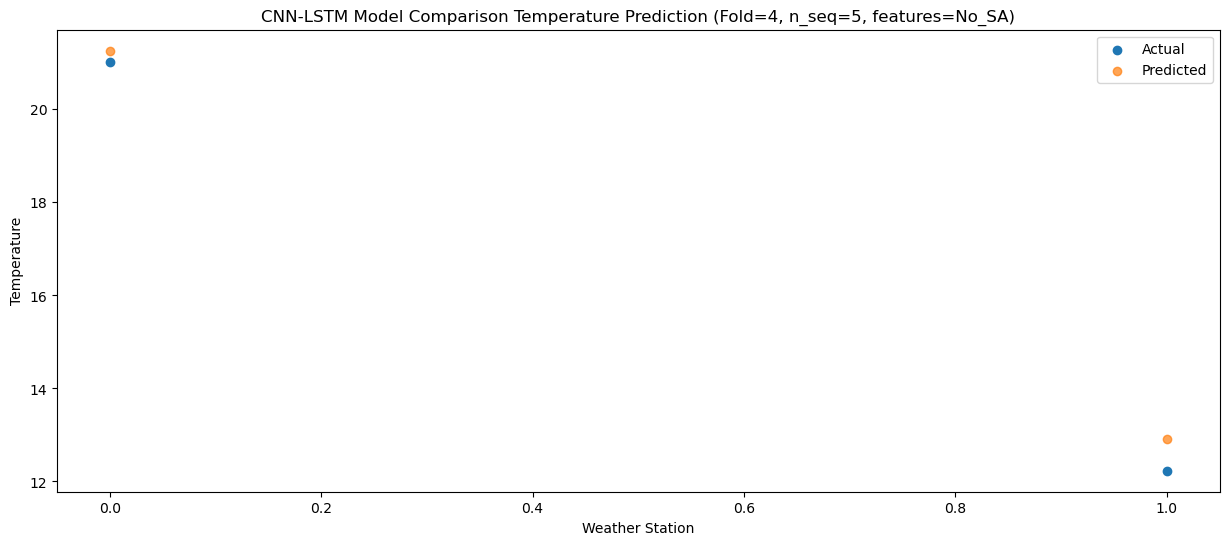

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.53  21.536633
1                1   12.79  13.426750


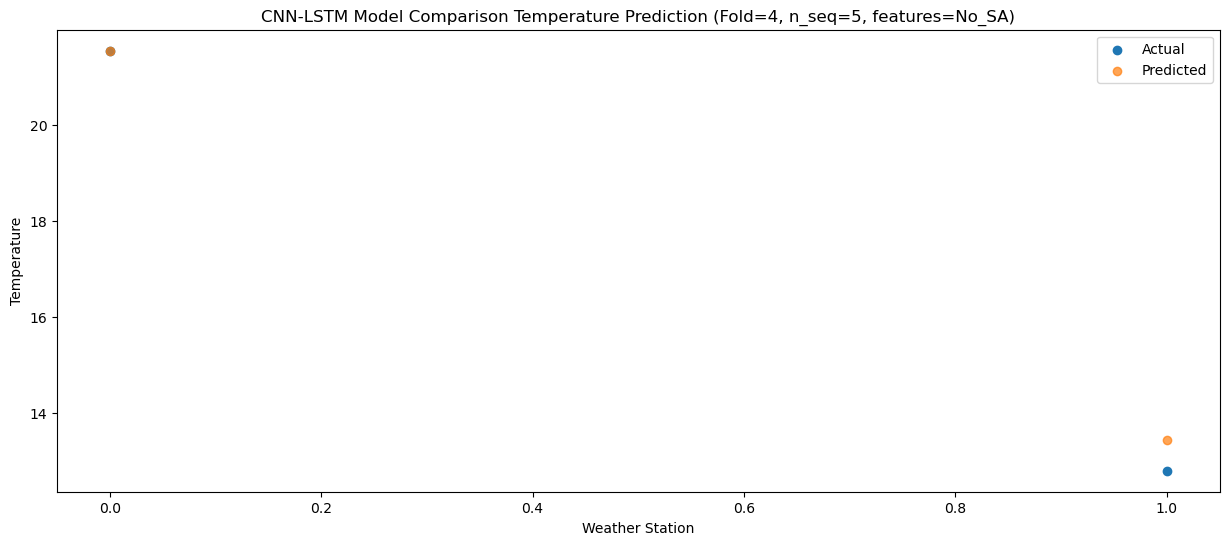

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   21.11  21.479107
1                1   13.11  13.528150


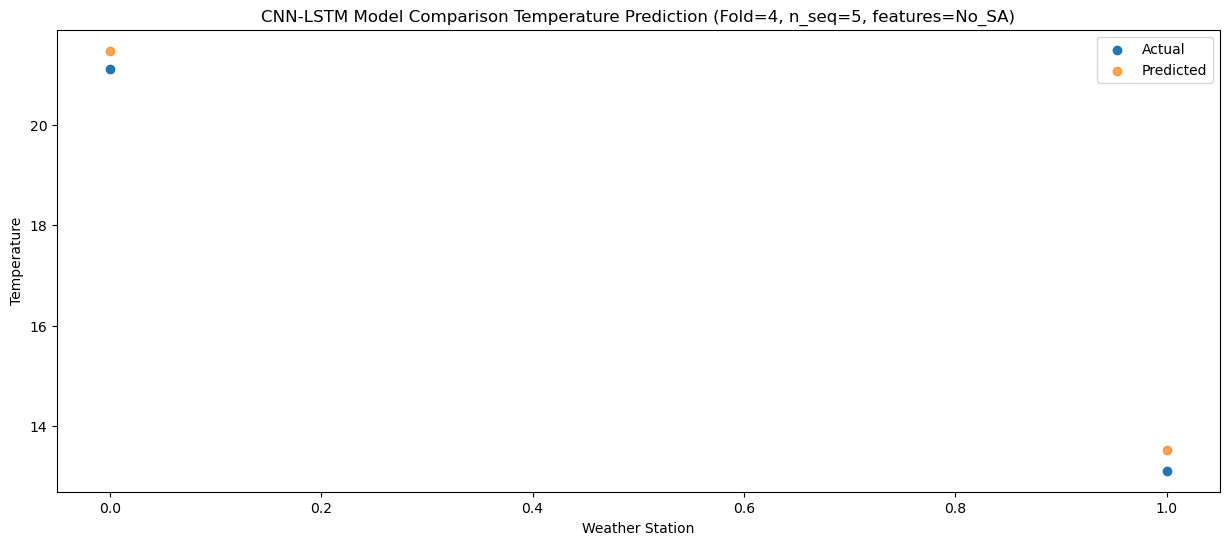

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.61  21.094135
1                1   12.24  12.888817


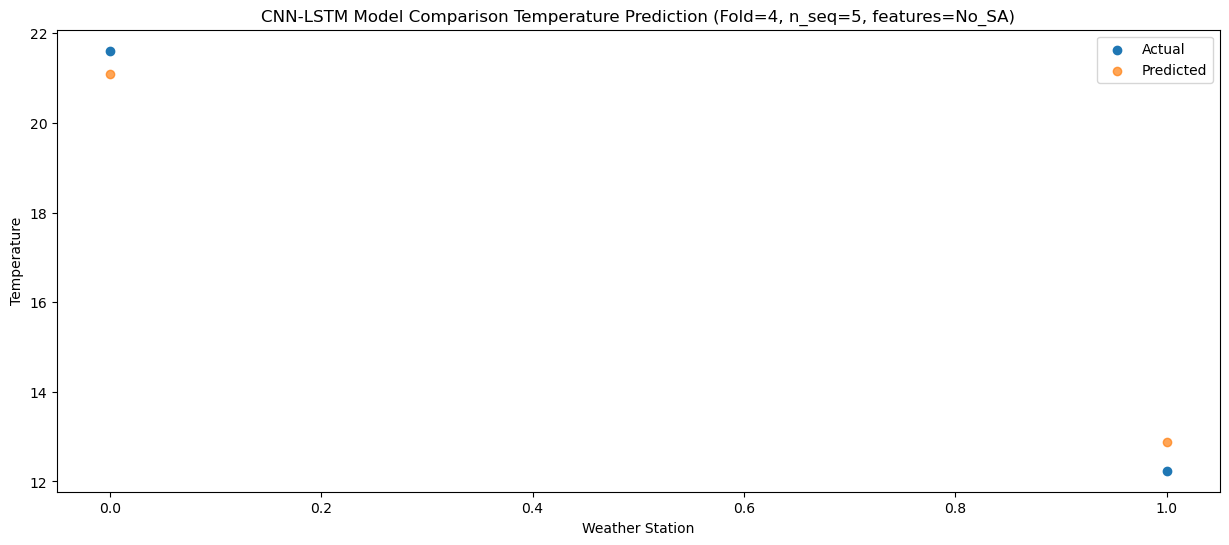

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   22.54  21.802906
1                1   13.72  13.833291


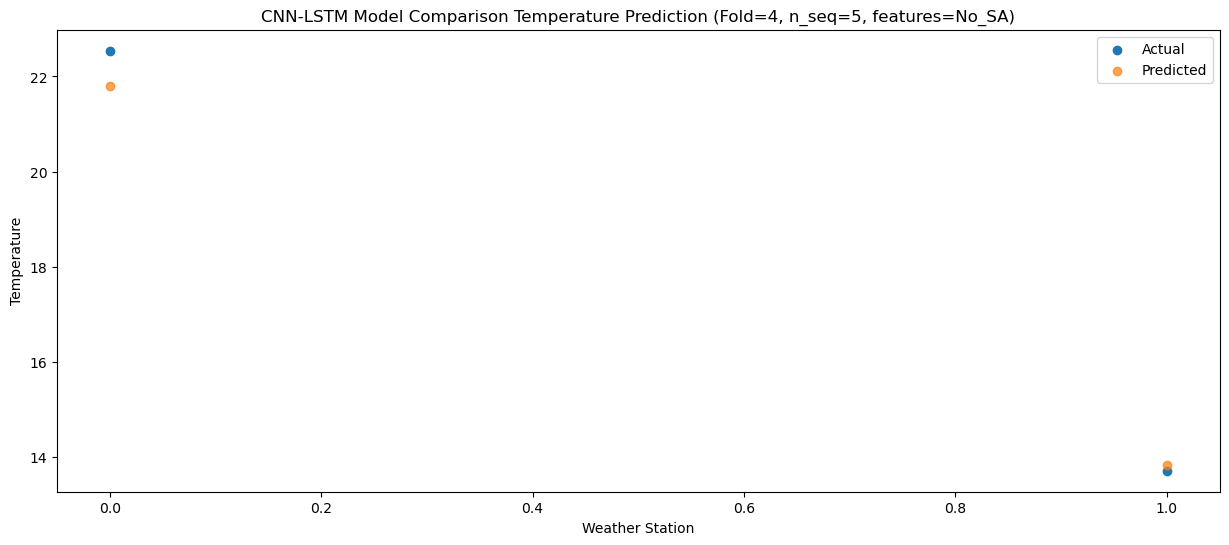

f, t:
[[21.01 12.23]
 [21.53 12.79]
 [21.11 13.11]
 [21.61 12.24]
 [22.54 13.72]]
[[21.26084728 12.90632122]
 [21.53663342 13.42674976]
 [21.4791071  13.5281499 ]
 [21.09413539 12.88881749]
 [21.80290638 13.83329052]]
Year at t+1:
t+1 SKRMSE: 0.510066
t+1 KRMSE: 0.510066
t+1 MAE: 0.463584
t+1 SKMAPE: 0.033620
t+1 R2_SCORE: 0.986500
t+1 KMAPE: 0.033620
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.450275
t+2 KRMSE: 0.450275
t+2 MAE: 0.321692
t+2 SKMAPE: 0.025047
t+2 R2_SCORE: 0.989383
t+2 KMAPE: 0.025047
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.394392
t+3 KRMSE: 0.394392
t+3 MAE: 0.393628
t+3 SKMAPE: 0.024690
t+3 R2_SCORE: 0.990278
t+3 KMAPE: 0.024690
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.586123
t+4 KRMSE: 0.586123
t+4 MAE: 0.582341
t+4 SKMAPE: 0.038440
t+4 R2_SCORE: 0.984348
t+4 KMAPE: 0.038440
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.527324
t+5 KRMSE: 0.527324
t+5 MAE: 0.425192
t+5 SKMAPE: 0.020479
t+5 R2_SCORE: 0.985702
t+5 KMAPE: 0.020479
t+5 PEARSON: 1

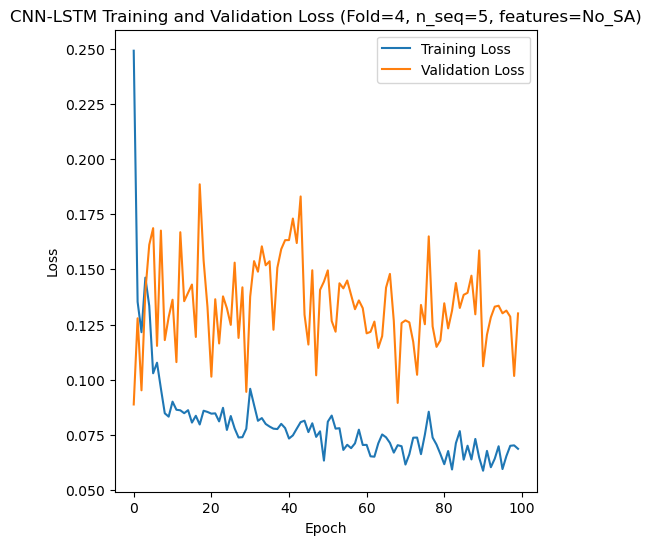

[[0.7010692937445588], [0.6693864081400939], [0.46640883479358736], [0.5059804707714728], [0.49801009843631694]]
[[array(0.70106929)], [array(0.66938641)], [array(0.46640883)], [array(0.50598047)], [array(0.4980101)]]
[[0.603509973768146], [0.519802069783211], [0.3898774311244493], [0.4275289262533189], [0.4372874920070172]]
[[0.03390841851083734], [0.02665542045284201], [0.024743027235590857], [0.029452137324870075], [0.028455154905993502]]
[[0.8994328616928624], [-0.12643586318880384], [0.9289423858296112], [-1.9691992577718653], [0.9872226653490676]]
[[array(0.03390842)], [array(0.02665542)], [array(0.02474303)], [array(0.02945214)], [array(0.02845515)]]
[[array(0.93937009)], [array(0.22925253)], [array(0.96941691)], [array(0.22151542)], [array(0.99437208)]]
[20.77 20.94 20.77 21.01 21.43 17.52 16.69 16.18 16.46 16.29 19.62 19.71
 18.79 19.13 19.97 19.82 20.34 19.95 19.95 21.26 17.6  16.9  17.14 17.11
 17.55 13.84 13.83 13.82 13.36 14.15 14.42 14.47 14.79 14.78 14.49 14.47
 14.35 14

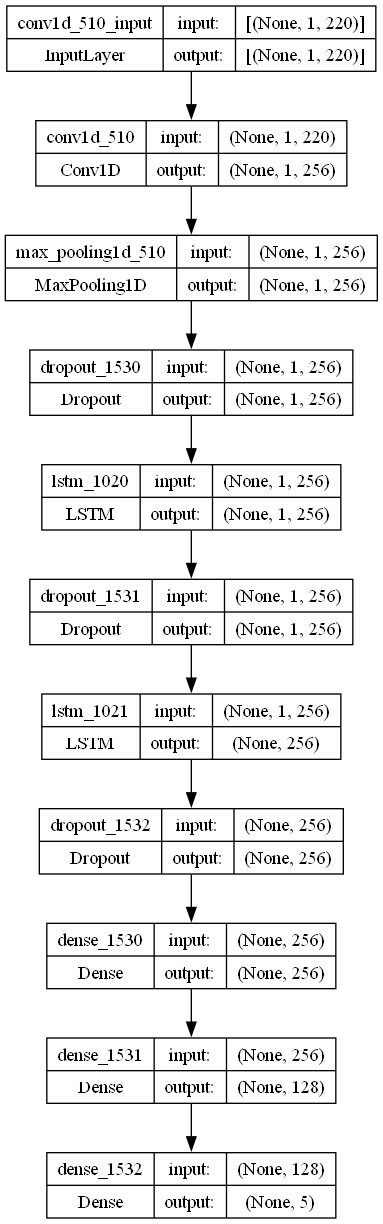

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.0013816094989016839
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 256
    dropout_rate = 0.23184814975125417

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S5_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)